## Imports

In [270]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss, auc
from matplotlib import pyplot as plt
import copy

sys.path.insert(0, "../")
from eval_metrics import lift_at_k
from active_learning_scores import least_confidence
from experimental_scores import probability_mass_above_given_label_score

# experimental version of label quality ensemble scores with additional weighting schemes
from label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Models

In [271]:
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224",
]

### Dictionaries to map to display names

In [203]:
# dictionaries to map to display name

method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
    "magl-False": "Mass Above Given Label",
}

model_display_name_dict = {
    "swin_base_patch4_window7_224": "Swin Transformer",
    "twins_pcpvt_base": "Twins PCPVT",
    "efficientnet_b1": "EfficientNet-B1",
    "resnet50d": "ResNet-50d",
    "resnet18": "ResNet-18",
}

## Load files from experiments
**Note:** we can refactor the code later to make it more concise but for now it reads the .npy files for each dataset within the for-loop

In [204]:
# TODO Add food-verified-train import

In [205]:
# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/cifar-10n-agg/results/cifar-10n-aggregate.zip'
# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/cifar-10n-agg/xval-results/cifar-10n-aggregate-xval.zip'

# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/cifar-10n-worst/results/cifar-10n-worst.zip'
# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/cifar-10n-worst/xval-results/cifar-10n-worst-xval.zip'

# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/cifar-10s/results/cifar-10s.zip'
# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/cifar-10s/xval-results/cifar-10s-xval.zip'

# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/roman-numeral/results/roman-numeral.zip'
# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/roman-numeral/xval-results/roman-numeral-xval.zip'

# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/food-101n/results/food-101n.zip'
# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/food-101n/xval-results/food-101n-xval.zip'

# !wget -nc 'https://cleanlab-public.s3.amazonaws.com/LabelErrorDetectionBenchmarks/food-101n/data/verified_train.tsv'

In [206]:
# !unzip -d cifar-10n-aggregate cifar-10n-aggregate.zip
# !unzip -d cifar-10n-aggregate-xval cifar-10n-aggregate-xval.zip
# !unzip -d cifar-10n-worst cifar-10n-worst.zip
# !unzip -d cifar-10n-worst-xval cifar-10n-worst-xval.zip
# !unzip -d cifar-10s cifar-10s.zip
# !unzip -d cifar-10s-xval cifar-10s-xval.zip
# !unzip -d roman-numeral roman-numeral.zip
# !unzip -d roman-numeral-xval roman-numeral-xval.zip
# !unzip -d food-101n food-101n.zip
# !unzip -d food-101n-xval food-101n-xval.zip

In [207]:
%%time

experiments = []

for xval in ["-xval", ""]:
    for model in models:
        print(model, xval)

        #### Andrew Ng DCAI Roman Numerals ####

        # read numpy files
        numpy_out_folder = f"./roman-numeral{xval}/roman-numeral_train_val_dataset_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
        label_errors_mask = np.load(numpy_out_folder + "label_errors_mask.npy")

        # store results of experiment
        experiment_results = {
            "dataset": "roman-numeral",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask,
            "type_train": xval,
        }
        experiments.append(experiment_results)


        #### Cifar-10n-worst

        # read numpy files
        numpy_out_folder = f"./cifar-10n-worst{xval}/cifar-10n-png_noise_type_worst_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        true_labels = np.load(numpy_out_folder + "true_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

        label_errors_mask = (true_labels != labels) # boolean mask of label errors

        # store results of experiment
        experiment_results = {
            "dataset": "cifar-10n-worst",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask,
            "type_train": xval,
        }
        experiments.append(experiment_results)


        #### Cifar-10n-aggregate

        # read numpy files
        numpy_out_folder = f"./cifar-10n-aggregate{xval}/cifar-10n-png_noise_type_aggre_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        true_labels = np.load(numpy_out_folder + "true_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

        label_errors_mask = (true_labels != labels) # boolean mask of label errors

        # store results of experiment
        experiment_results = {
            "dataset": "cifar-10n-aggregate",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask,
            "type_train": xval,
        }
        experiments.append(experiment_results)


        #### Cifar-10

        # synthetic noise amount 20% and sparsity 40% (as defined in confident learning paper)

        # read numpy files
        numpy_out_folder = f"./cifar-10s{xval}/cifar10_train_dataset_noise_amount_0.2_sparsity_0.4_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        true_labels = np.load(numpy_out_folder + "true_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

        label_errors_mask = (true_labels != labels) # boolean mask of label errors

        # store results of experiment
        experiment_results = {
            "dataset": "cifar-10",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask,
            "type_train": xval,
        }
        experiments.append(experiment_results)


        #### Food-101n

        # we only have verified labels for ~50K images so we have to evaluate within this subset

        # read numpy files
        numpy_out_folder = f"./food-101n{xval}/food-101n_cv_{model}/"
        pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
        labels = np.load(numpy_out_folder + "noisy_labels.npy")
        images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

        # read verified training labels
#         path_verified_train = "./food-101n/verified_train.tsv"
        path_verified_train = "./verified_train.tsv"
        df_verified_train = pd.read_csv(path_verified_train, sep='\t')

        # instantiate DataFrame with all training data
        df_image_paths = pd.DataFrame({
            "class_name/key": pd.Series(images).map(lambda f: "/".join(Path(f).parts[-2:]))
        })

        # join to append verification_label column
        df_image_paths_w_verified = df_image_paths.merge(df_verified_train, on="class_name/key", how="left")

        # subset of data with verified labels
        verified_subset_mask = ~df_image_paths_w_verified.verification_label.isnull().values

        # filter on verified subset
        pred_probs = pred_probs[verified_subset_mask]
        labels = labels[verified_subset_mask]
        images = images[verified_subset_mask]
        
        if max(labels) > 100:
            labels = np.array([label - 1 if label > 59 else label for label in labels])
        print(max(labels))

        # boolean mask of label errors
        label_errors_mask = df_image_paths_w_verified["verification_label"].values[verified_subset_mask] == 0

        # store results of experiment
        experiment_results = {
            "dataset": "food-101n",
            "model": model,
            "pred_probs": pred_probs,
            "labels": labels,
            "images": images,
            "label_errors_mask": label_errors_mask,
            "type_train": xval,
        }
        experiments.append(experiment_results)

resnet18 -xval
100
resnet50d -xval
100
efficientnet_b1 -xval
100
twins_pcpvt_base -xval
100
swin_base_patch4_window7_224 -xval
100
resnet18 
100
resnet50d 
100
efficientnet_b1 
100
twins_pcpvt_base 
100
swin_base_patch4_window7_224 
100
CPU times: user 20.6 s, sys: 1.58 s, total: 22.1 s
Wall time: 22.1 s


In [208]:
xval_experiments = experiments[:len(experiments)//2].copy()
noxval_experiments = experiments[len(experiments)//2:].copy()

In [209]:
## Todo: Ideally look at all methods for comparison
## scatterplot 1 metric and 1 method to make xval and nonxval plot (i.e. self_confidence auroc all model and all datasets)
## q are most points above or below zero (or do a box plot)

# fix sythetic dataset for magl correct implementation

# possibly reach out to ryan for spinning up app version of container


## Evaluate all results from individual models

In [210]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False),
    ("magl", False),
]

evaluations = []
precision_recall_curves = [] # store this separately
accuracy_list = []

for experiment in experiments:
    
    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]
    type_train = experiment["type_train"]
    
    print(dataset, model)
    
    accuracy = {
        "dataset": dataset,
        "model": model,
        "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
    }
    
    accuracy_list.append(accuracy)
    
    RESNET_18_FOOD_labels = None
    
    # finding label issues (score param agnostic)
    find_label_issues = cleanlab.filter.find_label_issues(labels, pred_probs, filter_by='confident_learning')
    num_label_issues = cleanlab.count.num_label_issues(labels, pred_probs)
        
    for score_param in score_params:        
        # compute scoring method
        method, adjust_pred_probs = score_param
        
        if "magl" in method:
            label_quality_scores = probability_mass_above_given_label_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=0.99)
        else:
            label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
            
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute prc auc scores
        auprc = auc(recall, precision)

        # lift at K where K = number of label errors
        lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())
        
        # lift at k=100
        lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)

        evaluation_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc,
            "auprc": auprc,
            "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
            "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
            "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
            "lift_at_num_label_errors": lift_at_num_label_errors,
            "lift_at_100": lift_at_100,
            "type_train": type_train,
        }

        # store evaluation results
        evaluations.append(evaluation_results)
        
        precision_recall_curve_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset,
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds,
            "type_train": type_train,
        }
        
        # store precision-recall curve results
        precision_recall_curves.append(precision_recall_curve_results)
        

    #### active learning scores to use as comparison
    
    al_scoring_funcs = {
        "entropy": get_normalized_entropy,
        "least_confidence": least_confidence
    }

    for al_method in al_scoring_funcs.keys():
        
        # active learning scoring function
        scoring_func = al_scoring_funcs[al_method]
    
        # score
        al_scores = scoring_func(pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, al_scores)
        
                # compute prc auc scores
        auprc = auc(recall, precision)


        # lift at K where K = number of label errors
        lift_at_num_label_errors = lift_at_k(label_errors_target, al_scores, k=label_errors_target.sum())
        
        # lift at k=100
        lift_at_100 = lift_at_k(label_errors_target, al_scores, k=100)

        evaluation_results = {
            "method": al_method,
            "adjust_pred_probs": False,
            "dataset": dataset,
            "model": model,
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc,
            "auprc": auprc,
            "lift_at_num_label_errors": lift_at_num_label_errors,
            "MAE_label_issues": np.sum(np.abs(find_label_issues ^ label_errors_target)) / len(find_label_issues),
            "confident_MAD": np.abs(np.sum(find_label_issues) - np.sum(label_errors_target)),
            "estimated_MAD": np.abs(num_label_issues - np.sum(label_errors_target)),
            "lift_at_100": lift_at_100,
            "type_train": type_train,
        }

        # store evaluation results
        evaluations.append(evaluation_results)

roman-numeral resnet18
cifar-10n-worst resnet18
cifar-10n-aggregate resnet18
cifar-10 resnet18
food-101n resnet18
roman-numeral resnet50d
cifar-10n-worst resnet50d
cifar-10n-aggregate resnet50d
cifar-10 resnet50d
food-101n resnet50d
roman-numeral efficientnet_b1
cifar-10n-worst efficientnet_b1
cifar-10n-aggregate efficientnet_b1
cifar-10 efficientnet_b1
food-101n efficientnet_b1
roman-numeral twins_pcpvt_base
cifar-10n-worst twins_pcpvt_base
cifar-10n-aggregate twins_pcpvt_base
cifar-10 twins_pcpvt_base
food-101n twins_pcpvt_base
roman-numeral swin_base_patch4_window7_224
cifar-10n-worst swin_base_patch4_window7_224
cifar-10n-aggregate swin_base_patch4_window7_224
cifar-10 swin_base_patch4_window7_224
food-101n swin_base_patch4_window7_224
roman-numeral resnet18
cifar-10n-worst resnet18
cifar-10n-aggregate resnet18
cifar-10 resnet18
food-101n resnet18
roman-numeral resnet50d
cifar-10n-worst resnet50d
cifar-10n-aggregate resnet50d
cifar-10 resnet50d
food-101n resnet50d
roman-numeral eff

### Evaluate change in results between xval and single pass pred_probs

In [211]:
xval_evaluations = evaluations[:len(evaluations)//2].copy()
noxval_evaluations = evaluations[len(evaluations)//2:].copy()

comparison_evaluations = []
i=0
for xval,noxval in zip(xval_evaluations, noxval_evaluations):
    print(xval)
    print(noxval)
    delta_auroc = noxval["auroc"] - xval["auroc"]
    delta_auprc = noxval["auprc"] - xval["auprc"]
    delta_lift_at_num_label_errors = noxval["lift_at_num_label_errors"] - xval["lift_at_num_label_errors"]
    delta_lift_at_100 = noxval["lift_at_100"] - xval["lift_at_100"]
    delta_MAE = noxval["MAE_label_issues"] - xval["MAE_label_issues"]
    
    evaluation_results = {
        "method": noxval["method"],
        "adjust_pred_probs": noxval["adjust_pred_probs"],
        "dataset": noxval["dataset"],
        "model": noxval["model"],
        "dataset_num_samples": noxval["dataset_num_samples"],
        "dataset_num_label_errors": noxval["dataset_num_label_errors"],
        "Δauroc": delta_auroc,
        "Δauprc": delta_auprc, 
        "Δlift_at_num_label_errors": delta_lift_at_num_label_errors,
        "Δlift_at_100": delta_lift_at_100,
        "ΔMAE_label_issues": delta_MAE
    }
    
    comparison_evaluations.append(evaluation_results)
    i+=1

{'method': 'self_confidence', 'adjust_pred_probs': False, 'dataset': 'roman-numeral', 'model': 'resnet18', 'dataset_num_samples': 2831, 'dataset_num_label_errors': 372, 'auroc': 0.8129583229479593, 'auprc': 0.5086618998483133, 'MAE_label_issues': 0.1402331331684917, 'confident_MAD': 261, 'estimated_MAD': 190, 'lift_at_num_label_errors': 3.825565094230547, 'lift_at_100': 5.935967741935484, 'type_train': '-xval'}
{'method': 'self_confidence', 'adjust_pred_probs': False, 'dataset': 'roman-numeral', 'model': 'resnet18', 'dataset_num_samples': 2880, 'dataset_num_label_errors': 373, 'auroc': 0.4697100130358856, 'auprc': 0.12118995687609888, 'MAE_label_issues': 0.13020833333333334, 'confident_MAD': 369, 'estimated_MAD': 368, 'lift_at_num_label_errors': 0.8901091792509109, 'lift_at_100': 1.0037533512064343, 'type_train': ''}
{'method': 'self_confidence', 'adjust_pred_probs': True, 'dataset': 'roman-numeral', 'model': 'resnet18', 'dataset_num_samples': 2831, 'dataset_num_label_errors': 372, 'au

In [212]:
pd.DataFrame(evaluations).head()

,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,auroc,auprc,MAE_label_issues,confident_MAD,estimated_MAD,lift_at_num_label_errors,lift_at_100,type_train
0,self_confidence,False,roman-numeral,resnet18,2831,372,0.812958,0.508662,0.140233,261,190,3.825565,5.935968,-xval
1,self_confidence,True,roman-numeral,resnet18,2831,372,0.817624,0.502700,0.140233,261,190,3.968768,5.707661,-xval
2,normalized_margin,False,roman-numeral,resnet18,2831,372,0.803109,0.416644,0.140233,261,190,3.539159,4.261720,-xval
3,normalized_margin,True,roman-numeral,resnet18,2831,372,0.804237,0.407956,0.140233,261,190,3.477786,4.109516,-xval
4,confidence_weighted_entropy,False,roman-numeral,resnet18,2831,372,0.810511,0.514628,0.140233,261,190,3.846023,6.012070,-xval


In [213]:
from IPython.display import display, HTML

df_comparison_evaluations = pd.DataFrame(comparison_evaluations)
for dataset in set(df_comparison_evaluations['dataset'].tolist()):
    print(dataset)
    print(display(HTML(df_comparison_evaluations.loc[df_comparison_evaluations['dataset'] == dataset].loc[df_comparison_evaluations['method'] == 'self_confidence'].loc[df_comparison_evaluations['model'] == 'swin_base_patch4_window7_224'].describe().to_html())))                              

cifar-10n-worst


,dataset_num_samples,dataset_num_label_errors,Δauroc,Δauprc,Δlift_at_num_label_errors,Δlift_at_100,ΔMAE_label_issues
count,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.00000
mean,50000.0,20104.0,0.000597,-0.000016,0.000371,0.0,-0.00298
std,0.0,0.0,0.001239,0.002047,0.009272,0.0,0.00000
min,50000.0,20104.0,-0.000279,-0.001463,-0.006186,0.0,-0.00298
25%,50000.0,20104.0,0.000159,-0.000739,-0.002907,0.0,-0.00298
50%,50000.0,20104.0,0.000597,-0.000016,0.000371,0.0,-0.00298
75%,50000.0,20104.0,0.001035,0.000708,0.003649,0.0,-0.00298
max,50000.0,20104.0,0.001473,0.001431,0.006928,0.0,-0.00298


None
cifar-10n-aggregate


,dataset_num_samples,dataset_num_label_errors,Δauroc,Δauprc,Δlift_at_num_label_errors,Δlift_at_100,ΔMAE_label_issues
count,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.0000
mean,50000.0,4505.0,-0.003184,-0.013747,-0.259916,0.0,0.0001
std,0.0,0.0,0.000334,0.001563,0.001742,0.0,0.0000
min,50000.0,4505.0,-0.003420,-0.014853,-0.261148,0.0,0.0001
25%,50000.0,4505.0,-0.003302,-0.014300,-0.260532,0.0,0.0001
50%,50000.0,4505.0,-0.003184,-0.013747,-0.259916,0.0,0.0001
75%,50000.0,4505.0,-0.003066,-0.013195,-0.259300,0.0,0.0001
max,50000.0,4505.0,-0.002948,-0.012642,-0.258684,0.0,0.0001


None
food-101n


,dataset_num_samples,dataset_num_label_errors,Δauroc,Δauprc,Δlift_at_num_label_errors,Δlift_at_100,ΔMAE_label_issues
count,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.000000
mean,52867.0,9746.0,-0.005929,-0.023079,-0.084323,0.027122,0.005504
std,0.0,0.0,0.002897,0.008828,0.000394,0.115071,0.000000
min,52867.0,9746.0,-0.007977,-0.029322,-0.084601,-0.054245,0.005504
25%,52867.0,9746.0,-0.006953,-0.026200,-0.084462,-0.013561,0.005504
50%,52867.0,9746.0,-0.005929,-0.023079,-0.084323,0.027122,0.005504
75%,52867.0,9746.0,-0.004904,-0.019958,-0.084184,0.067806,0.005504
max,52867.0,9746.0,-0.003880,-0.016837,-0.084044,0.108490,0.005504


None
roman-numeral


,dataset_num_samples,dataset_num_label_errors,Δauroc,Δauprc,Δlift_at_num_label_errors,Δlift_at_100,ΔMAE_label_issues
count,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.00000
mean,2880.0,373.0,-0.282196,-0.411294,-3.232576,-4.776681,-0.00302
std,0.0,0.0,0.104243,0.013022,0.015152,0.322874,0.00000
min,2880.0,373.0,-0.355907,-0.420502,-3.243290,-5.004988,-0.00302
25%,2880.0,373.0,-0.319051,-0.415898,-3.237933,-4.890834,-0.00302
50%,2880.0,373.0,-0.282196,-0.411294,-3.232576,-4.776681,-0.00302
75%,2880.0,373.0,-0.245341,-0.406690,-3.227219,-4.662528,-0.00302
max,2880.0,373.0,-0.208485,-0.402086,-3.221862,-4.548375,-0.00302


None
cifar-10


,dataset_num_samples,dataset_num_label_errors,Δauroc,Δauprc,Δlift_at_num_label_errors,Δlift_at_100,ΔMAE_label_issues
count,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.00000
mean,50000.0,9973.0,-0.004573,-0.025138,-0.237028,-0.050135,0.02622
std,0.0,0.0,0.000517,0.001636,0.052254,0.070902,0.00000
min,50000.0,9973.0,-0.004939,-0.026295,-0.273977,-0.100271,0.02622
25%,50000.0,9973.0,-0.004756,-0.025717,-0.255503,-0.075203,0.02622
50%,50000.0,9973.0,-0.004573,-0.025138,-0.237028,-0.050135,0.02622
75%,50000.0,9973.0,-0.004391,-0.024560,-0.218554,-0.025068,0.02622
max,50000.0,9973.0,-0.004208,-0.023982,-0.200079,0.000000,0.02622


None


In [214]:
# cross-validation accuracy
df_cv_accuracy = pd.DataFrame(accuracy_list[:len(accuracy_list)//2])
df_nocv_accuracy = pd.DataFrame(accuracy_list[len(accuracy_list)//2:])
df_accuracy =  df_cv_accuracy.copy()
df_accuracy['nocv_accuracy'] = df_nocv_accuracy["cv_accuracy"].tolist()
df_accuracy['Δaccuracy'] = df_accuracy["nocv_accuracy"].to_numpy() - df_accuracy["cv_accuracy"].to_numpy()

df_cv_accuracy_pivot = (
    pd.pivot_table(
        df_cv_accuracy, values="cv_accuracy", index=["model"], columns=["dataset"]
    )
    .reset_index()
    .sort_values(by="roman-numeral", ascending=False)
)

df_cv_accuracy_pivot["model"] = df_cv_accuracy_pivot.model.map(
    lambda x: model_display_name_dict[x]
)

df_nocv_accuracy_pivot = (
    pd.pivot_table(
        df_nocv_accuracy, values="cv_accuracy", index=["model"], columns=["dataset"]
    )
    .reset_index()
    .sort_values(by="roman-numeral", ascending=False)
)

df_nocv_accuracy_pivot["model"] = df_nocv_accuracy_pivot.model.map(
    lambda x: model_display_name_dict[x]
)

In [215]:
df_cv_accuracy_pivot

dataset,model,cifar-10,cifar-10n-aggregate,cifar-10n-worst,food-101n,roman-numeral
3,Swin Transformer,0.79048,0.90628,0.60592,0.726805,0.821971
4,Twins PCPVT,0.78098,0.89714,0.60154,0.682694,0.816319
1,ResNet-18,0.73976,0.87448,0.57788,0.612291,0.783116
0,EfficientNet-B1,0.73582,0.87154,0.58040,0.627140,0.711409
2,ResNet-50d,0.75506,0.87878,0.59190,0.628748,0.708937


In [216]:
df_nocv_accuracy_pivot

dataset,model,cifar-10,cifar-10n-aggregate,cifar-10n-worst,food-101n,roman-numeral
2,ResNet-50d,0.76422,0.90936,0.61268,0.718407,0.983681
4,Twins PCPVT,0.77734,0.88794,0.59656,0.693646,0.982639
0,EfficientNet-B1,0.78496,0.91052,0.62034,0.749390,0.973611
1,ResNet-18,0.76530,0.92606,0.62598,0.686572,0.959375
3,Swin Transformer,0.78358,0.90338,0.60482,0.697486,0.947917


In [217]:
df_accuracy

,dataset,model,cv_accuracy,nocv_accuracy,Δaccuracy
0,roman-numeral,resnet18,0.783116,0.959375,0.176259
1,cifar-10n-worst,resnet18,0.577880,0.625980,0.048100
2,cifar-10n-aggregate,resnet18,0.874480,0.926060,0.051580
3,cifar-10,resnet18,0.739760,0.765300,0.025540
4,food-101n,resnet18,0.612291,0.686572,0.074281
5,roman-numeral,resnet50d,0.708937,0.983681,0.274744
6,cifar-10n-worst,resnet50d,0.591900,0.612680,0.020780
7,cifar-10n-aggregate,resnet50d,0.878780,0.909360,0.030580
8,cifar-10,resnet50d,0.755060,0.764220,0.009160
9,food-101n,resnet50d,0.628748,0.718407,0.089659


In [218]:
# master table with AUROC and Lift at K evaluation metrics for all methods, datasets, and models
df_evaluations = pd.DataFrame(evaluations)

# append cv accuracy
df_evaluations = df_evaluations.merge(df_cv_accuracy, how="left", on=["dataset", "model"])

In [219]:
df_evaluations["method_adjust_pred_probs"] = (
    df_evaluations.method + "-" + df_evaluations.adjust_pred_probs.astype(str)
)
df_evaluations["dataset_model"] = df_evaluations.dataset + " | " + df_evaluations.model

df_evaluations["scoring_method"] = df_evaluations.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)
df_evaluations["model_name"] = df_evaluations.model.map(
    lambda x: model_display_name_dict[x]
)


df_evaluations["model_name_w_acc"] = df_evaluations.model_name + " (" + df_evaluations.cv_accuracy.round(4).astype(str) + ") "

In [220]:
# df_evaluations.to_csv("evaluation_all_experiments.csv")
df_evaluations.head(10)

,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,auroc,auprc,MAE_label_issues,confident_MAD,estimated_MAD,lift_at_num_label_errors,lift_at_100,type_train,cv_accuracy,method_adjust_pred_probs,dataset_model,scoring_method,model_name,model_name_w_acc
0,self_confidence,False,roman-numeral,resnet18,2831,372,0.812958,0.508662,0.140233,261,190,3.825565,5.935968,-xval,0.783116,self_confidence-False,roman-numeral | resnet18,Self Confidence,ResNet-18,ResNet-18 (0.7831)
1,self_confidence,True,roman-numeral,resnet18,2831,372,0.817624,0.502700,0.140233,261,190,3.968768,5.707661,-xval,0.783116,self_confidence-True,roman-numeral | resnet18,Adjusted Self Confidence,ResNet-18,ResNet-18 (0.7831)
2,normalized_margin,False,roman-numeral,resnet18,2831,372,0.803109,0.416644,0.140233,261,190,3.539159,4.261720,-xval,0.783116,normalized_margin-False,roman-numeral | resnet18,Normalized Margin,ResNet-18,ResNet-18 (0.7831)
3,normalized_margin,True,roman-numeral,resnet18,2831,372,0.804237,0.407956,0.140233,261,190,3.477786,4.109516,-xval,0.783116,normalized_margin-True,roman-numeral | resnet18,Adjusted Normalized Margin,ResNet-18,ResNet-18 (0.7831)
4,confidence_weighted_entropy,False,roman-numeral,resnet18,2831,372,0.810511,0.514628,0.140233,261,190,3.846023,6.012070,-xval,0.783116,confidence_weighted_entropy-False,roman-numeral | resnet18,Confidence Weighted Entropy,ResNet-18,ResNet-18 (0.7831)
5,magl,False,roman-numeral,resnet18,2831,372,0.807268,0.474059,0.140233,261,190,3.784650,5.403253,-xval,0.783116,magl-False,roman-numeral | resnet18,Mass Above Given Label,ResNet-18,ResNet-18 (0.7831)
6,entropy,False,roman-numeral,resnet18,2831,372,0.732535,0.474059,0.140233,261,190,2.679941,3.576801,-xval,0.783116,entropy-False,roman-numeral | resnet18,Entropy,ResNet-18,ResNet-18 (0.7831)
7,least_confidence,False,roman-numeral,resnet18,2831,372,0.727816,0.474059,0.140233,261,190,2.598111,3.196290,-xval,0.783116,least_confidence-False,roman-numeral | resnet18,Least Confidence,ResNet-18,ResNet-18 (0.7831)
8,self_confidence,False,cifar-10n-worst,resnet18,50000,20104,0.963435,0.951197,0.156440,5578,1661,2.173462,2.487067,-xval,0.577880,self_confidence-False,cifar-10n-worst | resnet18,Self Confidence,ResNet-18,ResNet-18 (0.5779)
9,self_confidence,True,cifar-10n-worst,resnet18,50000,20104,0.956146,0.935252,0.156440,5578,1661,2.148844,2.487067,-xval,0.577880,self_confidence-True,cifar-10n-worst | resnet18,Adjusted Self Confidence,ResNet-18,ResNet-18 (0.5779)


In [221]:
df_comparison_evaluations.head(10)

,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,Δauroc,Δauprc,Δlift_at_num_label_errors,Δlift_at_100,ΔMAE_label_issues
0,self_confidence,False,roman-numeral,resnet18,2880,373,-0.343248,-0.387472,-2.935456,-4.932214,-0.010025
1,self_confidence,True,roman-numeral,resnet18,2880,373,-0.217444,-0.344412,-2.995858,-4.703908,-0.010025
2,normalized_margin,False,roman-numeral,resnet18,2880,373,-0.336897,-0.297480,-2.711151,-3.566814,-0.010025
3,normalized_margin,True,roman-numeral,resnet18,2880,373,-0.211382,-0.258271,-2.484176,-3.337398,-0.010025
4,confidence_weighted_entropy,False,roman-numeral,resnet18,2880,373,-0.338977,-0.392803,-2.935213,-5.085528,-0.010025
5,magl,False,roman-numeral,resnet18,2880,373,-0.337775,-0.353452,-2.894541,-4.708347,-0.010025
6,entropy,False,roman-numeral,resnet18,2880,373,-0.260452,-0.353452,-1.789832,-2.573048,-0.010025
7,least_confidence,False,roman-numeral,resnet18,2880,373,-0.258080,-0.353452,-1.708002,-2.424172,-0.010025
8,self_confidence,False,cifar-10n-worst,resnet18,50000,20104,-0.000596,0.000128,0.015340,0.000000,0.031200
9,self_confidence,True,cifar-10n-worst,resnet18,50000,20104,0.001380,0.004468,0.016825,0.000000,0.031200


# Creating comparison plots

In [222]:
df = df_comparison_evaluations.copy()

df = df.merge(df_cv_accuracy, how="left", on=["dataset", "model"])

df["method_adjust_pred_probs"] = (
    df.method + "-" + df.adjust_pred_probs.astype(str)
)
df["dataset_model"] = df.dataset + " | " + df.model

df["scoring_method"] = df.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)
df["model_name"] = df.model.map(
    lambda x: model_display_name_dict[x]
)


df["model_name_w_acc"] = df.model_name + " (" + df.cv_accuracy.round(4).astype(str) + ") "

df_auroc = (
    pd.pivot_table(
        df,
        values="Δauroc",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_lift_at_num_errors = (
    pd.pivot_table(
        df,
        values="Δlift_at_num_label_errors",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_lift_at_100 = (
    pd.pivot_table(
        df,
        values="Δlift_at_100",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_auprc = (
    pd.pivot_table(
        df,
        values="Δauprc",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

In [193]:
def draw_plot_auroc(df, title="AUROC",alpha=0.9):
    df['dataset_model'] = df.apply(lambda x: x['dataset'] + ' | ' + x['model_name_w_acc'],axis=1)

    # Draw plot
    plt.figure(figsize=(10, 10), dpi=80)

    s = 60
    marker = "o"

    s0 = plt.scatter(
        df["Confidence Weighted Entropy"], df.index, s=s, alpha=alpha, marker=marker
    )
    s1 = plt.scatter(df["Self Confidence"], df.index, s=s, alpha=alpha, marker=marker)
    s2 = plt.scatter(df["Adjusted Self Confidence"], df.index, s=s, alpha=alpha, marker=marker)
    s3 = plt.scatter(
        df["Normalized Margin"], df.index, s=s, alpha=alpha, marker=marker
    )
    s4 = plt.scatter(
        df["Adjusted Normalized Margin"], df.index, s=s, alpha=alpha, marker=marker
    )
    # s5 = plt.scatter(df["entropy-False"], df.index, s=s, alpha=alpha, marker=marker)
    # s6 = plt.scatter(df["least_confidence-False"], df.index, s=s, alpha=alpha, marker=marker)

    # for x, y, tex in zip(df["confidence_weighted_entropy-False"], df.index, df["confidence_weighted_entropy-False"]):
    #     t = plt.text(x, y, round(tex, 1), horizontalalignment='center',
    #                  verticalalignment='center', fontdict={'color':'white'})

    plt.title("AUROC", fontsize=18)
    plt.yticks(df.index, df.dataset_model)
    plt.legend(
        (s0, s1, s2, s3, s4),
        (
            "Confidence Weighted Entropy (False)",
            "Self Confidence (False)",
            "Self Confidence (True)",
            "Normalized Margin (False)",
            "Normalized Margin (True)",
        ),
        loc="upper center",
        bbox_to_anchor=(0.5, 1.2),
        ncol=3,
        fancybox=True,
        shadow=True,
        fontsize=12,
    )

    plt.show()
    
def draw_plot_lift(df, title="LIFT", alpha=1, markersize=8, save_title=True):
    # pointer
    plt.rcParams["figure.figsize"] = (15, 8)

    df = df.sort_values(by=["dataset", "Confidence Weighted Entropy"])
    df["dataset_model"] = df.dataset + " | " + df.model_name_w_acc

    labels = df["dataset_model"].tolist()
    x = np.arange(len(labels))  # the label locations

    s0 = df["Confidence Weighted Entropy"].tolist()
    s1 = df["Self Confidence"].tolist()
    s2 = df["Adjusted Self Confidence"].tolist()
    s3 = df["Normalized Margin"].tolist()
    s4 = df["Adjusted Normalized Margin"].tolist()

    jf = 0.15 # jitter factor

    fig, ax = plt.subplots()
    _ = ax.plot(s0, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Confidence Weighted Entropy", markersize=markersize, alpha=alpha)
    _ = ax.plot(s1, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Self Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s2, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Self Confidence", markersize=markersize, alpha=alpha)
    _ = ax.plot(s3, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Normalized Margin", markersize=markersize, alpha=alpha)
    _ = ax.plot(s4, x + np.random.uniform(-jf, jf), marker="o", linestyle="None", label="Adjusted Normalized Margin", markersize=markersize, alpha=alpha)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_xlabel("Dataset | Model(accuracy)", loc="left", rotation="horizontal")
#     ax.set_ylabel("Dataset | Model(accuracy)")
    
    if save_title:
        ax.set_title(title, fontsize=24, fontweight="bold")
    ax.set_yticks(x, labels)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
    
    # plot horizontal lines between each model group
    a = [(x[i] + x[i+1]) / 2 for i in range(4,len(x)-4,5)]    
    [ax.axhline(y=i, linestyle='solid',c='black',linewidth=0.75) for i in a]

    fig.tight_layout()
    plt.savefig(f'./figs-final-xval/delta-scatter-difference-{title}.png', dpi=200)
    plt.show()

In [194]:
# draw_plot_auroc(df_auroc, title="AUROC")

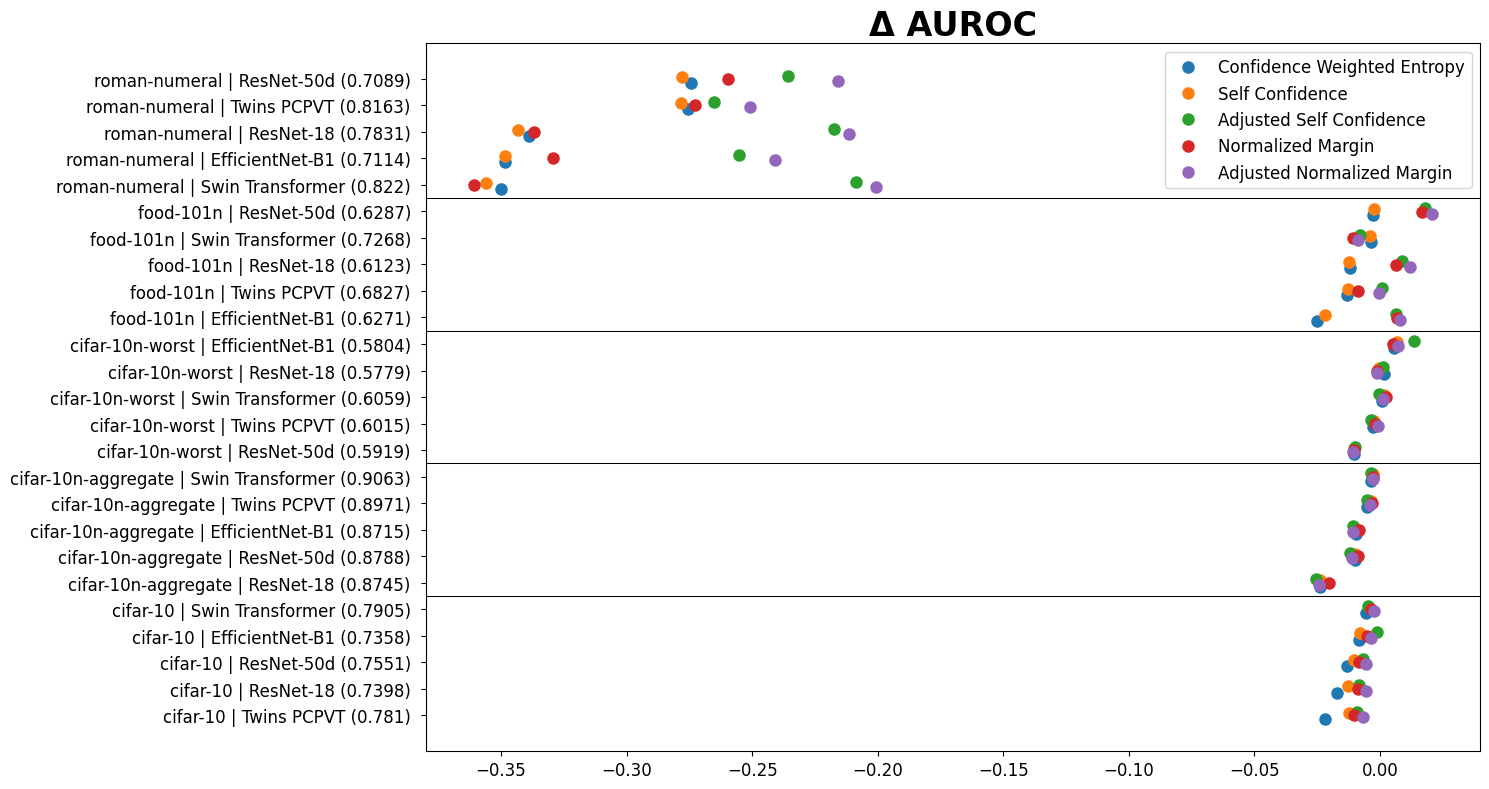

In [195]:
draw_plot_lift(df_auroc, title="Δ AUROC")

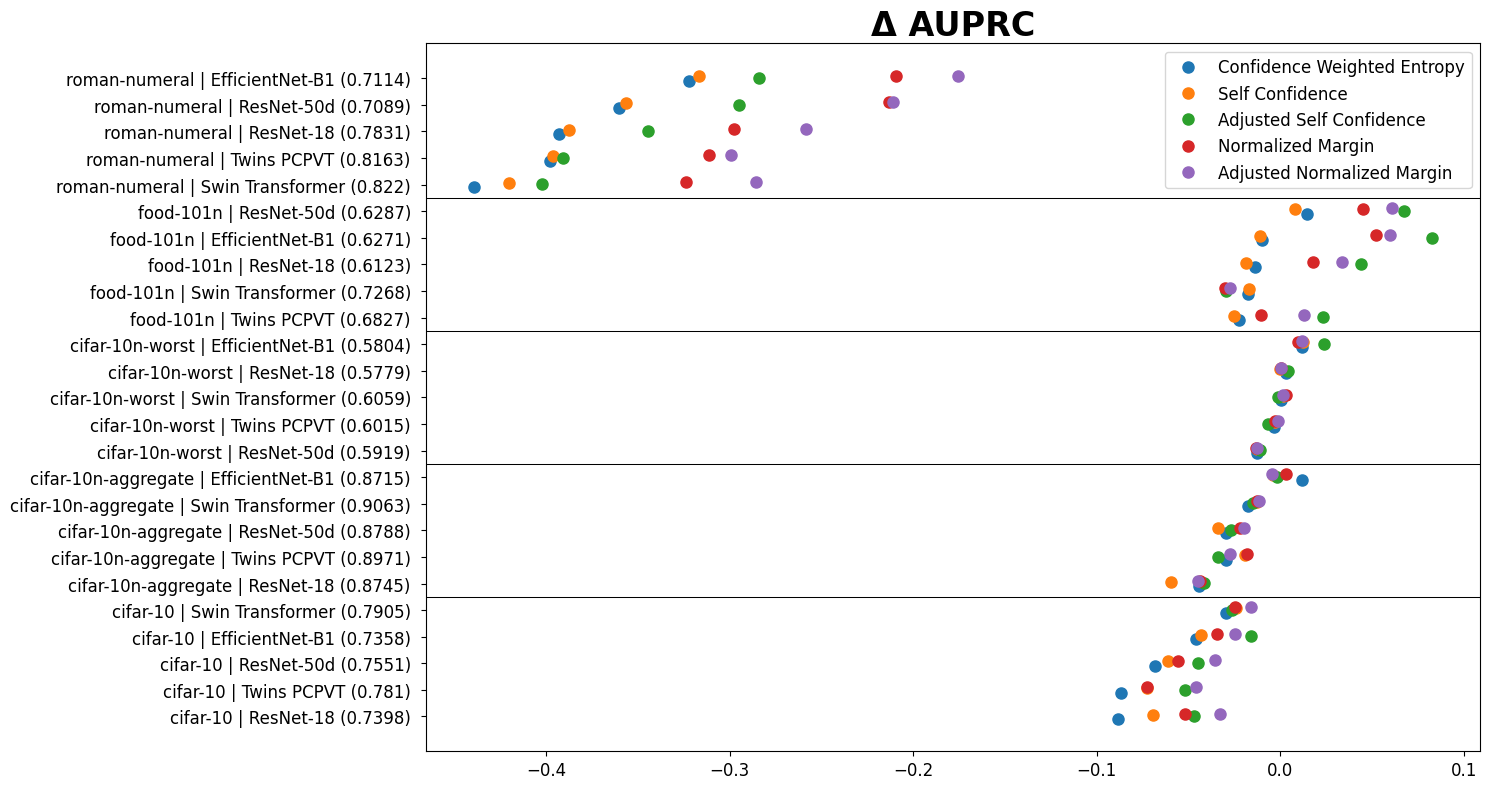

In [196]:
draw_plot_lift(df_auprc, title="Δ AUPRC", alpha=1, markersize=8)

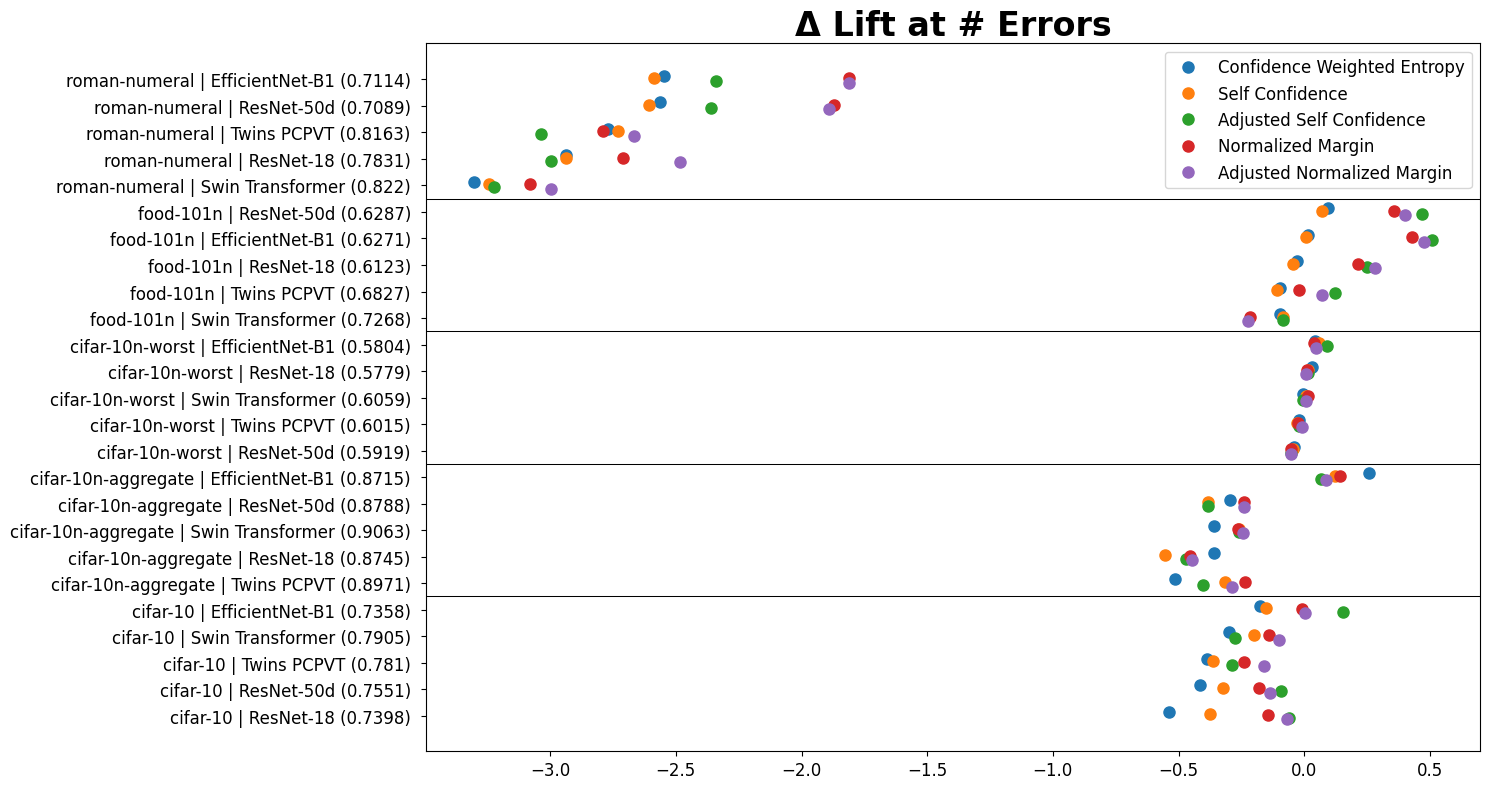

In [197]:
draw_plot_lift(df_lift_at_num_errors, title="Δ Lift at # Errors", alpha=1, markersize=8)

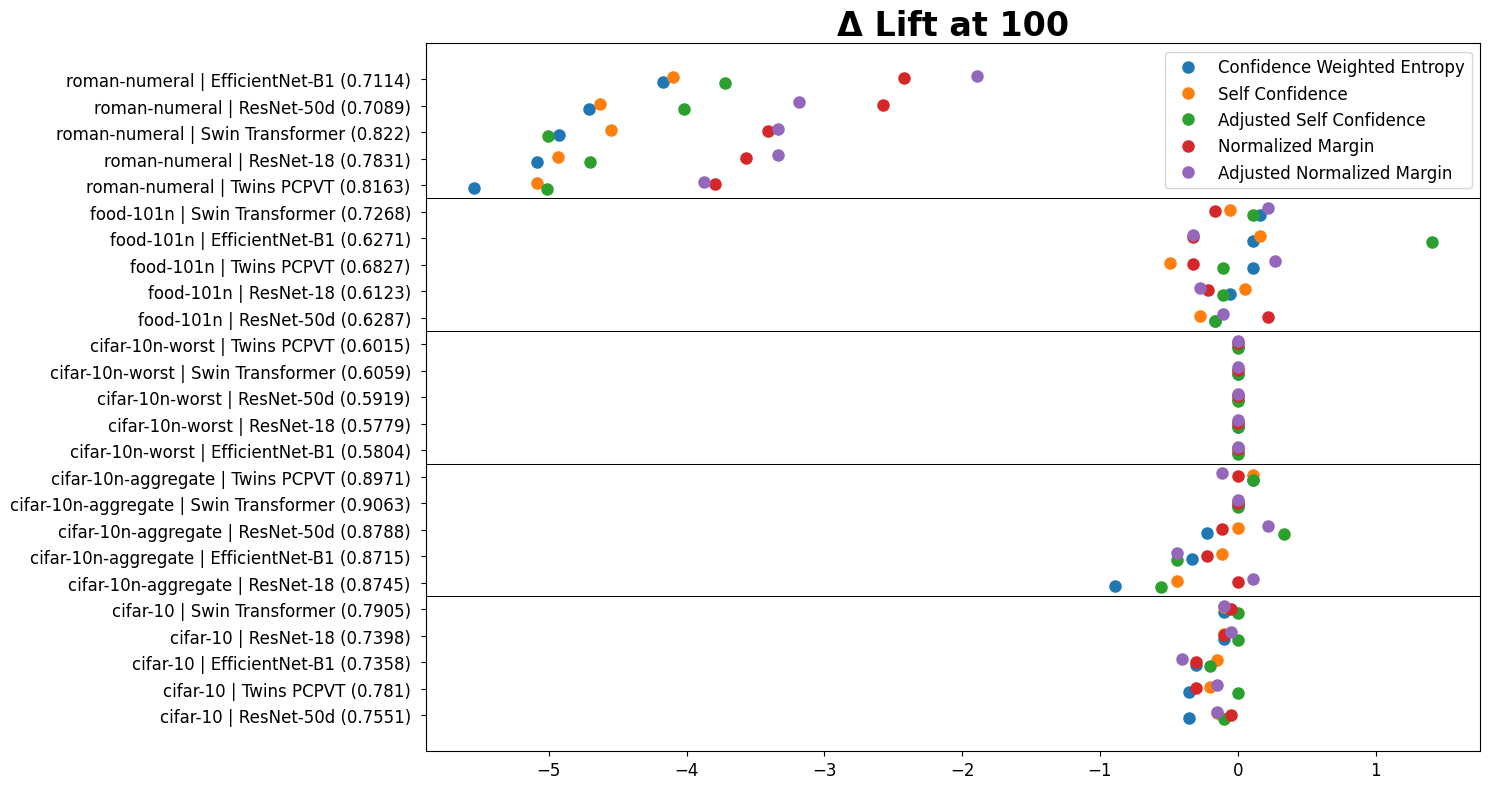

In [198]:
draw_plot_lift(df_lift_at_100, title="Δ Lift at 100", alpha=1, markersize=8)

### Just plotting values not change 
AUROC for LED achieved by label quality scores for each dataset and model. Models are ordered by accuracy on each dataset.

In [189]:
df_xval_evaluations = df_evaluations[df_evaluations['type_train'] == '-xval']

In [190]:
df_evaluations_auroc = (
    pd.pivot_table(
        df_xval_evaluations,
        values="auroc",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

df_evaluations_auprc = (
    pd.pivot_table(
        df_xval_evaluations,
        values="auprc",
        index=["dataset", "model_name", "model_name_w_acc"],
        columns=["scoring_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "model_name"])
)

In [259]:
df_table = pd.DataFrame(df_evaluations_auroc[df_evaluations_auroc['model_name'] == 'Swin Transformer']).round(4)
df_table = df_table.drop(['model_name', 'model_name_w_acc'], axis=1).set_index('dataset')
df_table = df_table.T
df_table = df_table[['roman-numeral','food-101n','cifar-10n-worst','cifar-10n-aggregate','cifar-10']]
df_table

dataset,roman-numeral,food-101n,cifar-10n-worst,cifar-10n-aggregate,cifar-10
scoring_method,,,,,
Adjusted Normalized Margin,0.8218,0.8911,0.9929,0.9955,0.9993
Adjusted Self Confidence,0.8373,0.9001,0.9892,0.9950,0.9977
Confidence Weighted Entropy,0.8366,0.9234,0.9868,0.9951,0.9993
Entropy,0.7716,0.8159,0.6380,0.7572,0.3541
Least Confidence,0.7620,0.8102,0.6549,0.7613,0.3637
Mass Above Given Label,0.8311,0.9084,0.9913,0.9957,0.9995
Normalized Margin,0.8247,0.8906,0.9921,0.9960,0.9991
Self Confidence,0.8350,0.9223,0.9905,0.9958,0.9996


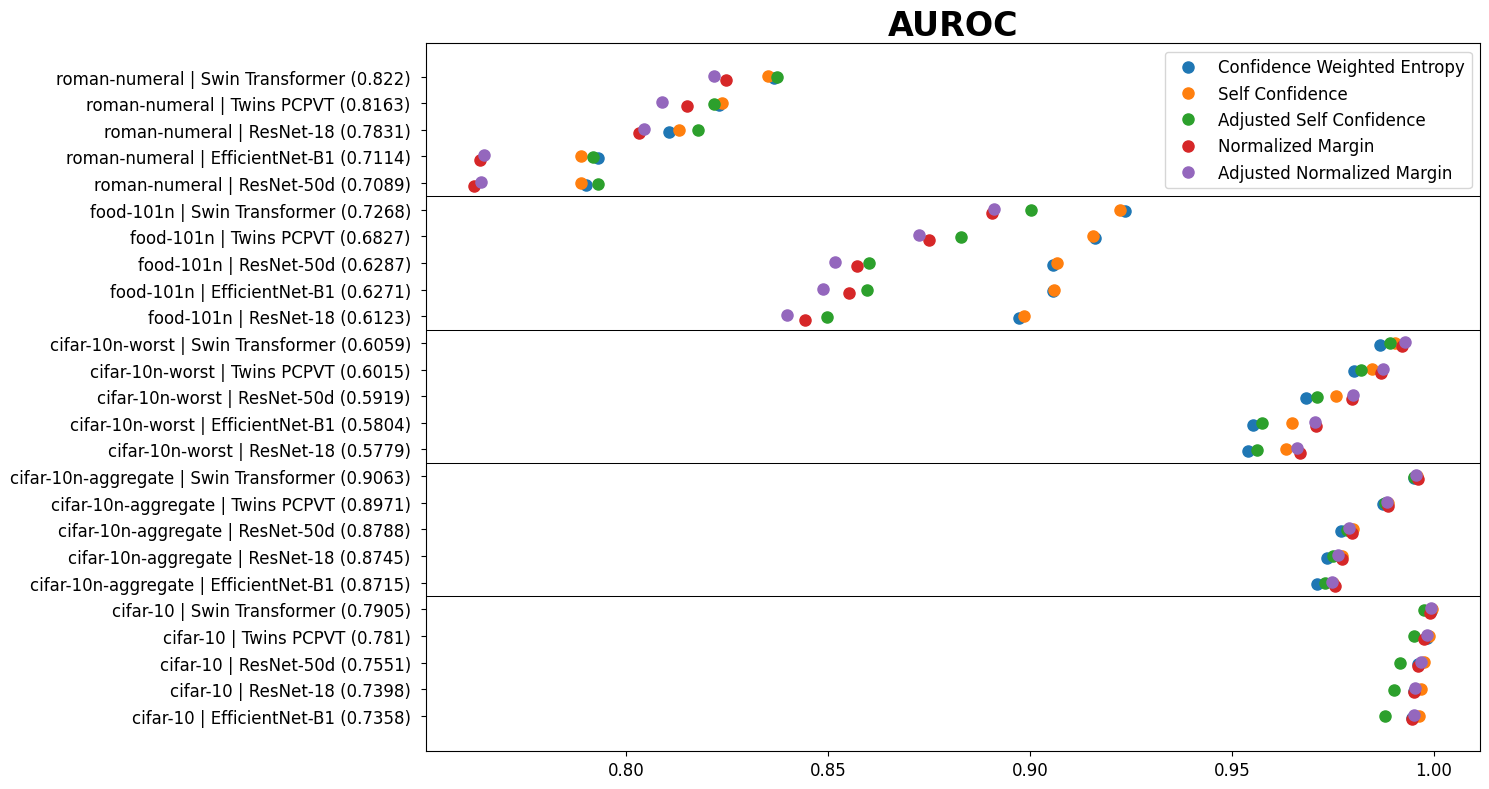

In [191]:
draw_plot_lift(df_evaluations_auroc, title="AUROC", alpha=1, markersize=8)

In [260]:
df_table = pd.DataFrame(df_evaluations_auprc[df_evaluations_auroc['model_name'] == 'Swin Transformer']).round(4)
df_table = df_table.drop(['model_name', 'model_name_w_acc'], axis=1).set_index('dataset')
df_table = df_table.T
df_table = df_table[['roman-numeral','food-101n','cifar-10n-worst','cifar-10n-aggregate','cifar-10']]
df_table

dataset,roman-numeral,food-101n,cifar-10n-worst,cifar-10n-aggregate,cifar-10
scoring_method,,,,,
Adjusted Normalized Margin,0.4434,0.5853,0.9906,0.9744,0.9968
Adjusted Self Confidence,0.5660,0.6390,0.9855,0.9742,0.9858
Confidence Weighted Entropy,0.5626,0.7687,0.9831,0.9727,0.9965
Entropy,0.5057,0.6836,0.9893,0.9757,0.9978
Least Confidence,0.5057,0.6836,0.9893,0.9757,0.9978
Mass Above Given Label,0.5057,0.6836,0.9893,0.9757,0.9978
Normalized Margin,0.4410,0.5823,0.9896,0.9745,0.9956
Self Confidence,0.5416,0.7577,0.9879,0.9770,0.9983


In [269]:
l = df_table.iloc[4].to_list()
ans = ""
for v in l:
    ans += f"{v} & "
ans

'0.5057 & 0.6836 & 0.9893 & 0.9757 & 0.9978 & '

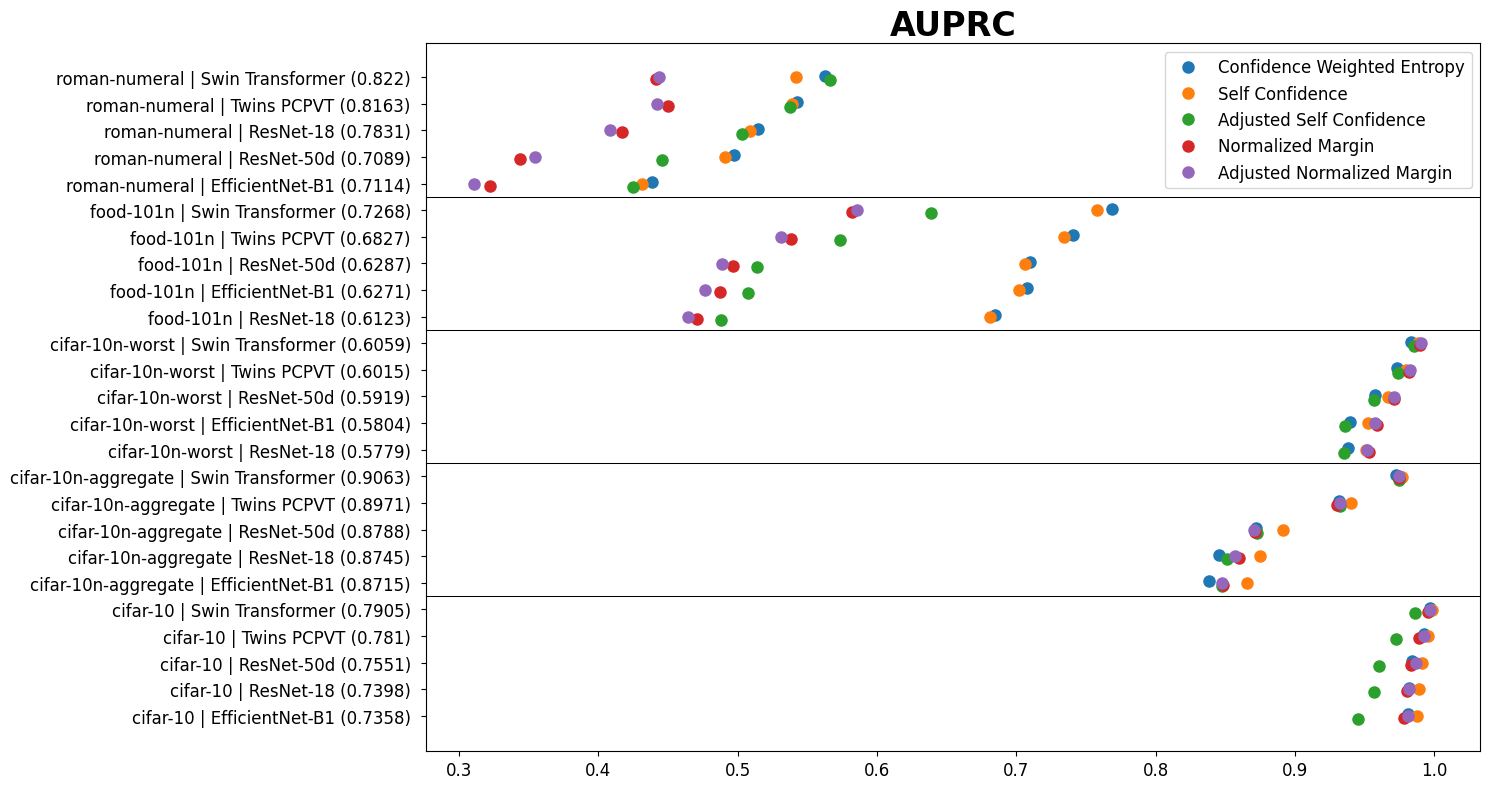

In [192]:
draw_plot_lift(df_evaluations_auprc, title="AUPRC", alpha=1, markersize=8)

## Precision/recall curve for Swin Transformer model Food 101N dataset 
### xval results (comparable to s5 in paper)

In [229]:
%%time

def get_df_filter_by(labels, pred_probs, label_errors_target):
    # pointer
    true_label_issues = label_errors_target

    # code below adapted from v2.0.0 docs
    # https://colab.research.google.com/github/cleanlab/cleanlab-docs/blob/master/v2.0.0/tutorials/indepth_overview.ipynb#scrollTo=kCfdx2gOLmXS

    # Find label issues with different filter_by options
    filter_by_list = [
        "prune_by_noise_rate",
        "prune_by_class",
        "both",
        "confident_learning",
        "predicted_neq_given",
    ]

    results = []

    for filter_by in filter_by_list:

        # Find label issues
        label_issues = cleanlab.filter.find_label_issues(
            labels=labels, 
            pred_probs=pred_probs, 
            filter_by=filter_by
        )

        precision = precision_score(true_label_issues, label_issues)
        recall = recall_score(true_label_issues, label_issues)
        f1 = f1_score(true_label_issues, label_issues)
        acc = accuracy_score(true_label_issues, label_issues)

        result = {
            "filter_by": filter_by,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": acc,
            "num_est_label_issues": label_issues.sum()
        }

        results.append(result)

    # summary of results
    # pd.DataFrame(results).sort_values(by='f1', ascending=False)

    df_filter_by = pd.DataFrame(results)

    return df_filter_by

def plot_curve(labels, pred_probs, label_errors_target,  model='swin_base_patch4_window7_224', dataset='food-101n', marker="o", linestyle='solid'):
    plt.rcParams["figure.figsize"] = (15, 10)

    score_params = \
    [
        ("self_confidence", False),
        # ("self_confidence", True),
        ("normalized_margin", False),
        # ("normalized_margin", True),
        ("confidence_weighted_entropy", False)
    ]

    df_list = []

    for score_param in score_params:

        method, adjust_pred_probs = score_param
        label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # save to DataFrame
        # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
        # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
        df_temp = pd.DataFrame({
            "precision": precision[:-1],
            "recall": recall[:-1],
            "thresholds": thresholds,
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs
        })

        df_list.append(df_temp)

        # plot
        plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}", linestyle=linestyle)

    # combine DataFrames
    # df_all = pd.concat(df_list)
    df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)
    
    # plot single dot (precision, recall) for each filter_by option
    for index, row in df_filter_by.iterrows():
        filter_by = row["filter_by"]
        precision = row["precision"]
        recall = row["recall"]
        plt.plot(recall, precision, marker=marker, markersize=10, label=filter_by)

    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title(f"Precision-Recall Curve: Label Error Detection on {dataset} \n Model: {model}", fontsize=20, fontweight="bold")
    # plt.suptitle("")
    plt.legend()
#     plt.show()

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.4 µs


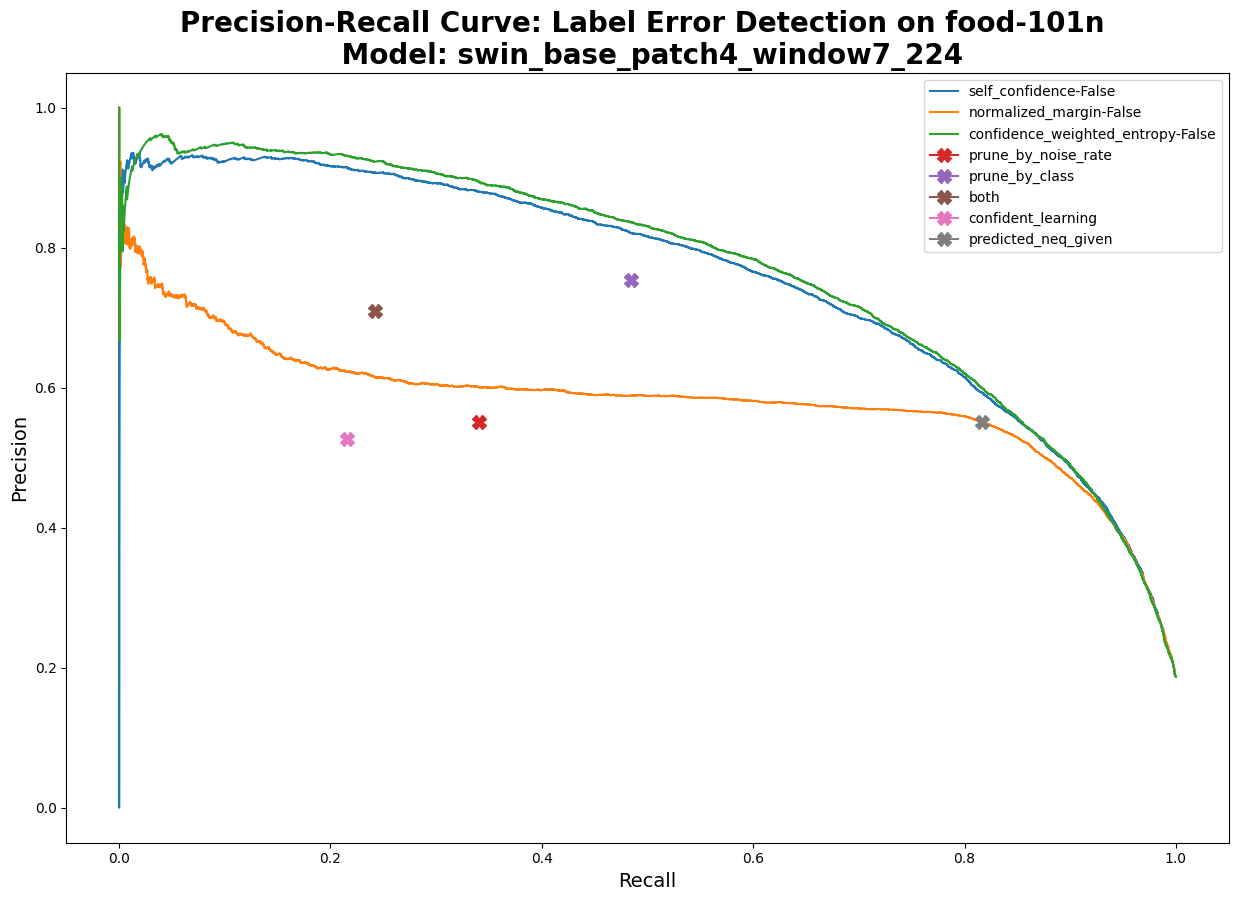

In [230]:
df = pd.DataFrame(experiments)
swin_food_results_xval = df.loc[df['model']=='swin_base_patch4_window7_224'].loc[df['dataset']=='food-101n'].iloc[0]

labels = swin_food_results_xval["labels"]
pred_probs = swin_food_results_xval["pred_probs"]
label_errors_target = swin_food_results_xval["label_errors_mask"]

plot_curve(labels, pred_probs, label_errors_target, marker="X", linestyle='solid')
plt.show()

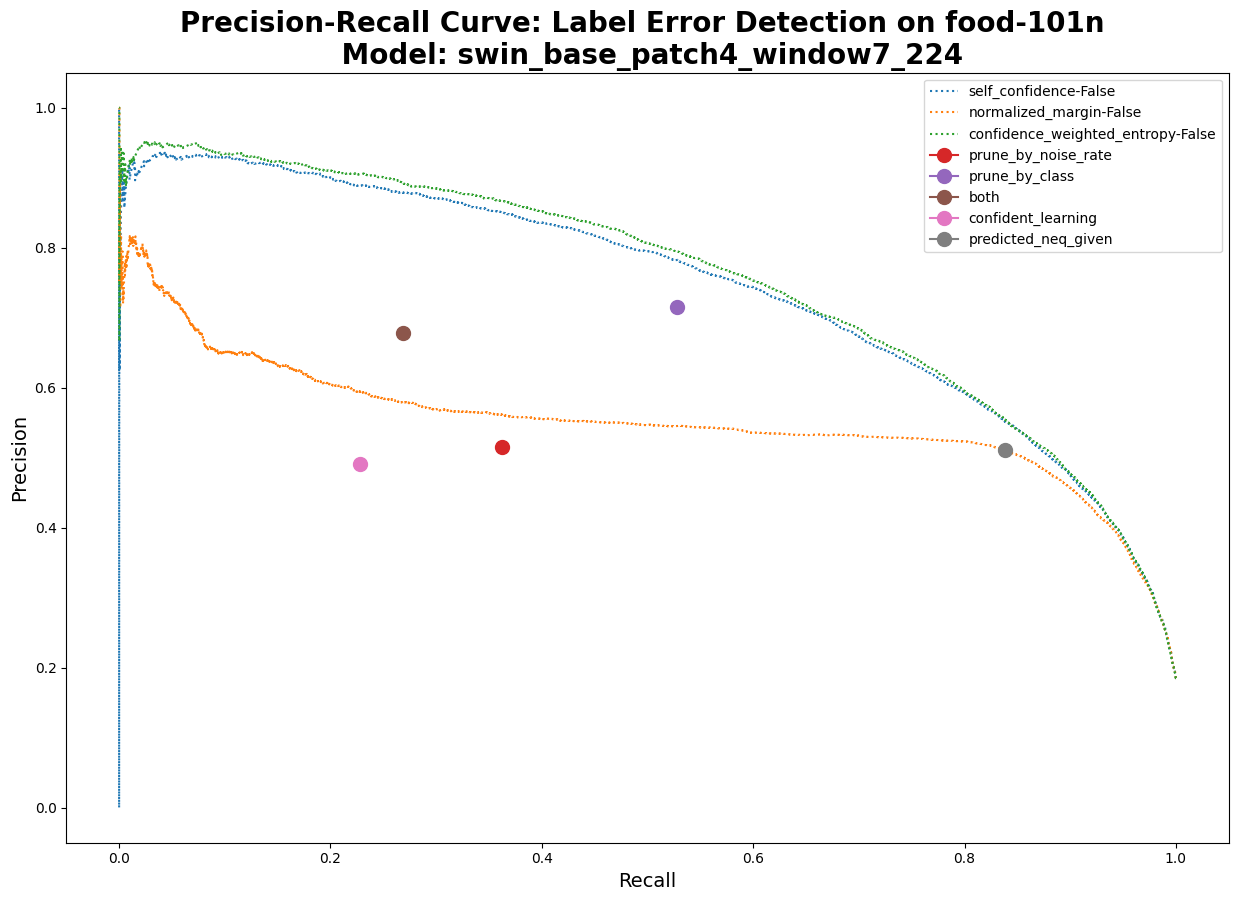

In [231]:
swin_food_results = df.loc[df['model']=='swin_base_patch4_window7_224'].loc[df['dataset']=='food-101n'].iloc[1]

labels = swin_food_results["labels"]
pred_probs = swin_food_results["pred_probs"]
label_errors_target = swin_food_results["label_errors_mask"]

plot_curve(labels, pred_probs, label_errors_target, marker="o", linestyle='dotted')
plt.show()

# Plot curves for swin transformer model for paper per dataset 

In [241]:
def plot_swin_curves(dset='food-101n'):
    swin_food_results_xval = df.loc[df['model']=='swin_base_patch4_window7_224'].loc[df['dataset']==dset].iloc[0]
    labels = swin_food_results_xval["labels"]
    pred_probs = swin_food_results_xval["pred_probs"]
    label_errors_target = swin_food_results_xval["label_errors_mask"]
    marker = "o"
    linestyle = "solid"

    score_params = \
    [
        ("self_confidence", False),
        # ("self_confidence", True),
        ("normalized_margin", False),
        # ("normalized_margin", True),
        ("confidence_weighted_entropy", False)
    ]

    df_list = []

    plt.rcParams["figure.figsize"] = (15, 10)
    # plt.suptitle(f"Precision-Recall Curve: Label Error Detection on {dataset} \n Model: {model}")
    line_colors = []
    for score_param in score_params:

        method, adjust_pred_probs = score_param
        label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # save to DataFrame
        # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
        # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
        df_temp = pd.DataFrame({
            "precision": precision[:-1],
            "recall": recall[:-1],
            "thresholds": thresholds,
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs
        })

        df_list.append(df_temp)

        # plot
    #     plt.subplot(1, 2, 1)
        line, = plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}", linestyle=linestyle)
        line_colors.append(line.get_color())

    # combine DataFrames
    # df_all = pd.concat(df_list)
    df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)

    dot_colors = []
    # plot single dot (precision, recall) for each filter_by option
    for index, row in df_filter_by.iterrows():
        filter_by = row["filter_by"]
        precision = row["precision"]
        recall = row["recall"]
        dot, = plt.plot(recall, precision, marker=marker, markersize=10, label=filter_by, linestyle='None')
        print("Color of the most recent plot line: ", filter_by, dot.get_color())
        dot_colors.append(dot.get_color())
        plt.grid(visible=True, which='major', axis='both')


    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    # plt.title(f"Training: 5-fold Cross Validation", fontsize=20, fontweight="bold")
    # plt.suptitle("")
    plt.legend()

    swin_food_results = df.loc[df['model']=='swin_base_patch4_window7_224'].loc[df['dataset']==dset].iloc[1]

    labels = swin_food_results["labels"]
    pred_probs = swin_food_results["pred_probs"]
    label_errors_target = swin_food_results["label_errors_mask"]
    marker = "X"
    linestyle = "dashed"

    df_list = []
    i = 0
    for score_param in score_params:

        method, adjust_pred_probs = score_param
        label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # save to DataFrame
        # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
        # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
        df_temp = pd.DataFrame({
            "precision": precision[:-1],
            "recall": recall[:-1],
            "thresholds": thresholds,
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs
        })

        df_list.append(df_temp)

        # plot
    #     plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}", linestyle=linestyle, color=f'{line_colors[i]}')
        plt.grid(visible=True, which='major', axis='both')
        i+=1

    # combine DataFrames
    # df_all = pd.concat(df_list)
    df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)

    # plot single dot (precision, recall) for each filter_by option
    i = 0
    for index, row in df_filter_by.iterrows():
        filter_by = row["filter_by"]
        precision = row["precision"]
        recall = row["recall"]
        dot, = plt.plot(recall, precision, marker=marker, markersize=10, label=filter_by, linestyle='None', color=f'{dot_colors[i]}')
        print("Color of the most recent plot line: ", filter_by, dot.get_color())
        i+=1

    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    # plt.title(f"Training: Single Pass", fontsize=20, fontweight="bold")
    # plt.suptitle("")
    # plt.legend()

    plt.savefig(f'./figs/delta-prc-5fold-vs-single-pass-{dset}.png', dpi=300)

    plt.show()

Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f
Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f


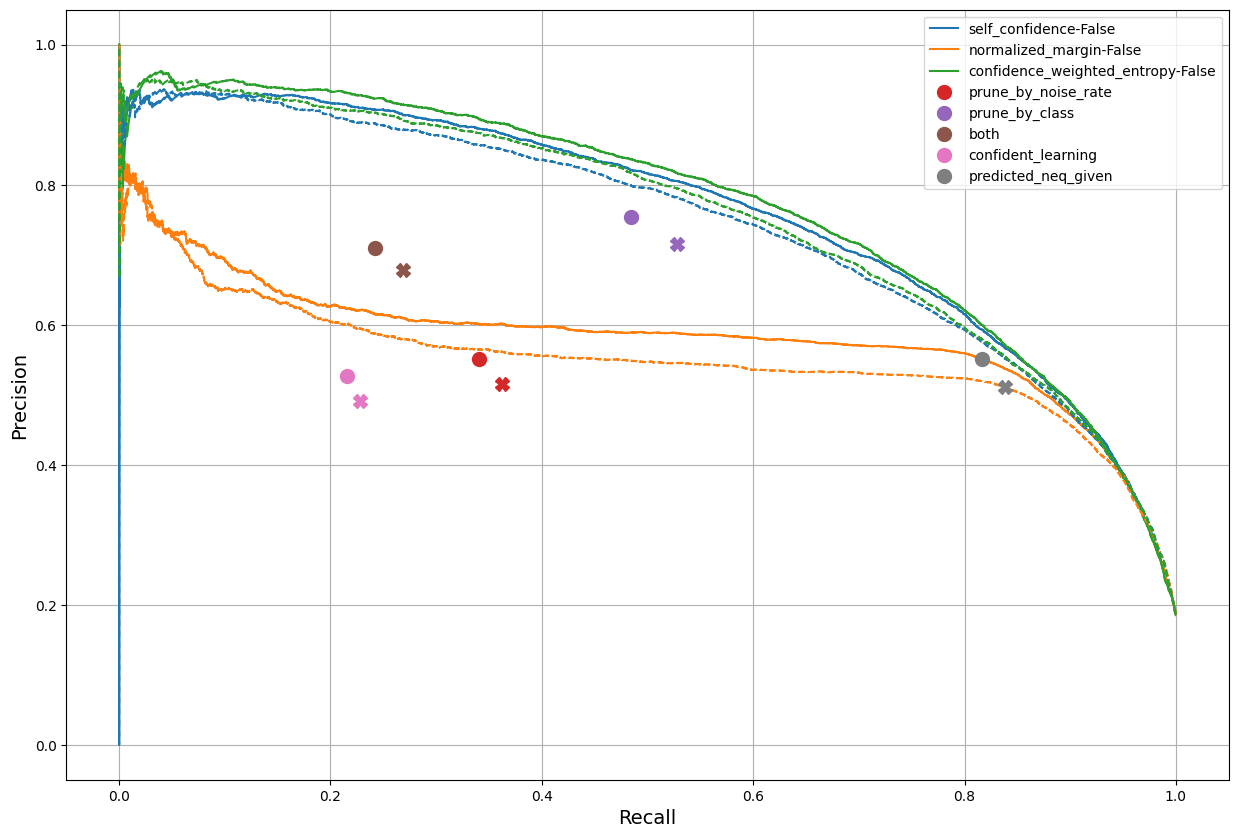

In [242]:
plot_swin_curves('food-101n')

Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f
Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f


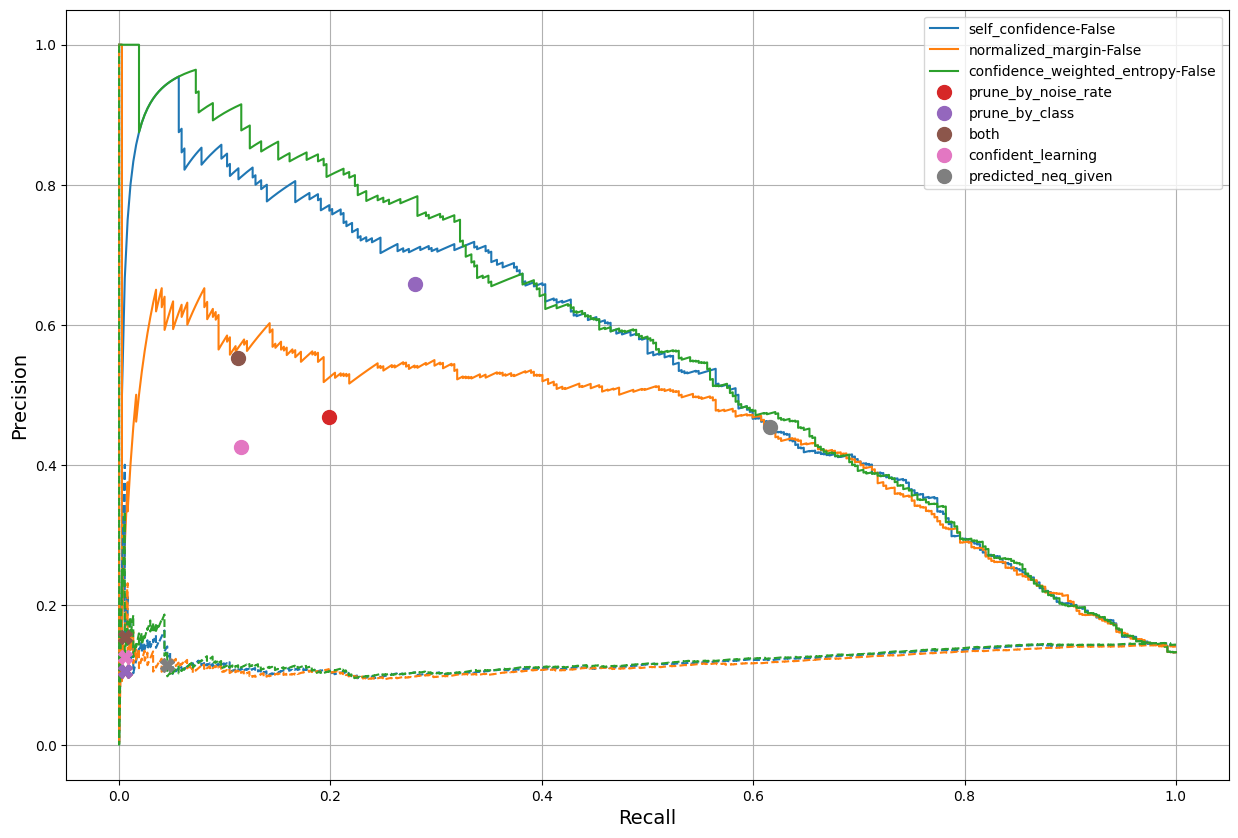

In [243]:
plot_swin_curves('roman-numeral')

Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f
Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f


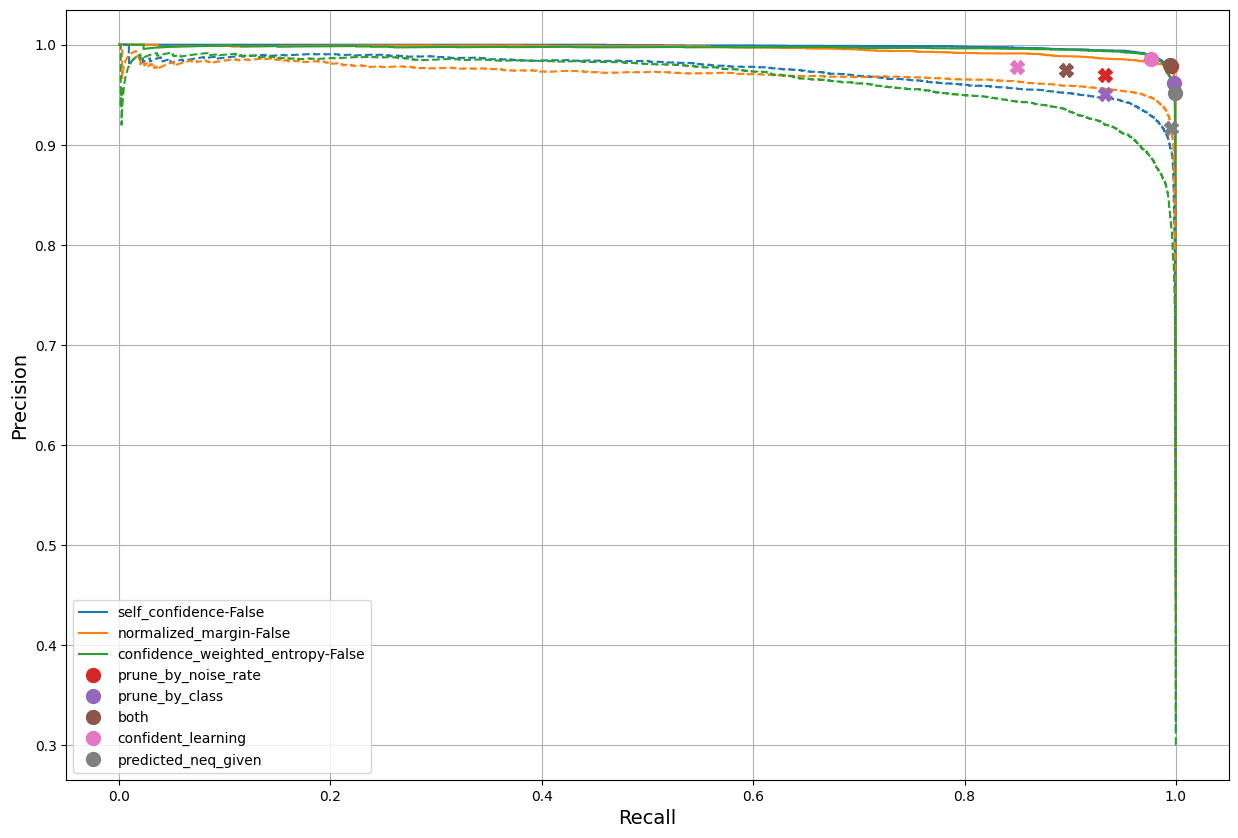

In [244]:
plot_swin_curves('cifar-10')

Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f
Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f


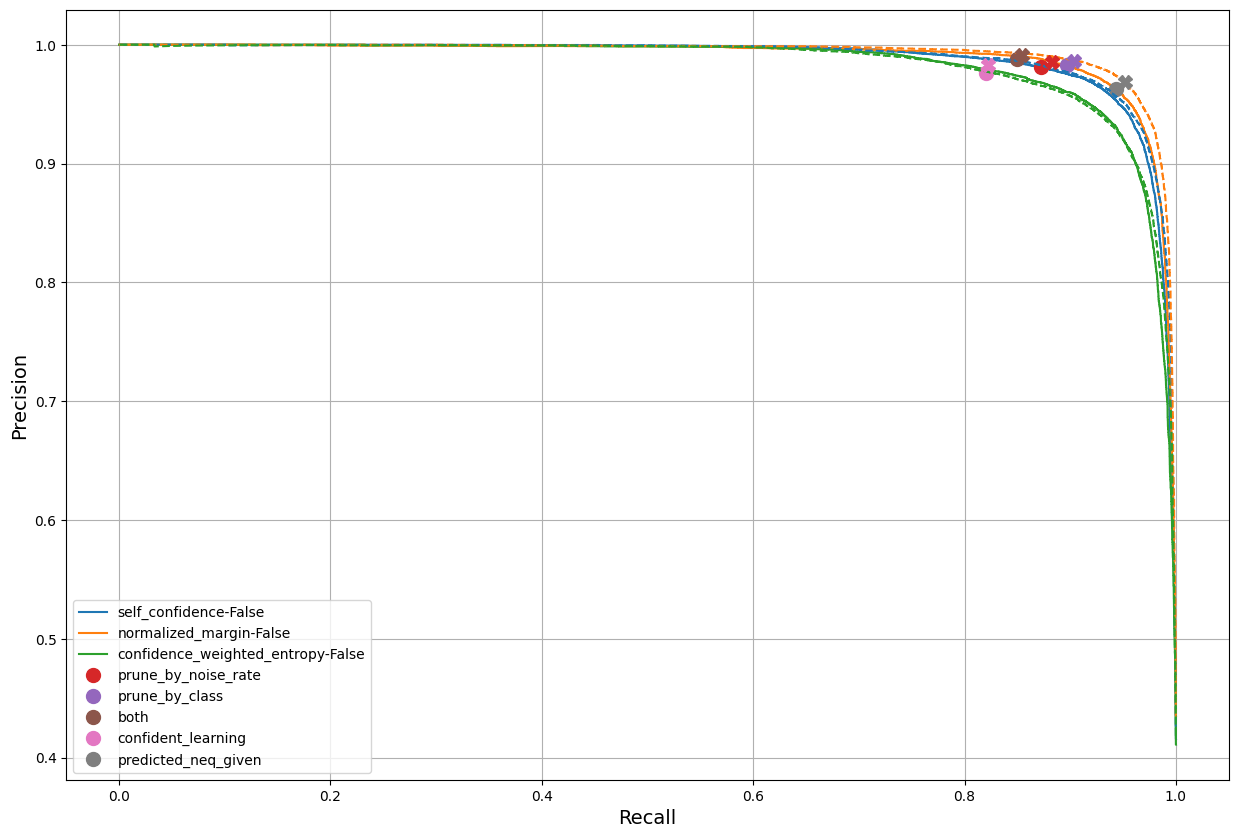

In [245]:
plot_swin_curves('cifar-10n-worst')

Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f
Color of the most recent plot line:  prune_by_noise_rate #d62728
Color of the most recent plot line:  prune_by_class #9467bd
Color of the most recent plot line:  both #8c564b
Color of the most recent plot line:  confident_learning #e377c2
Color of the most recent plot line:  predicted_neq_given #7f7f7f


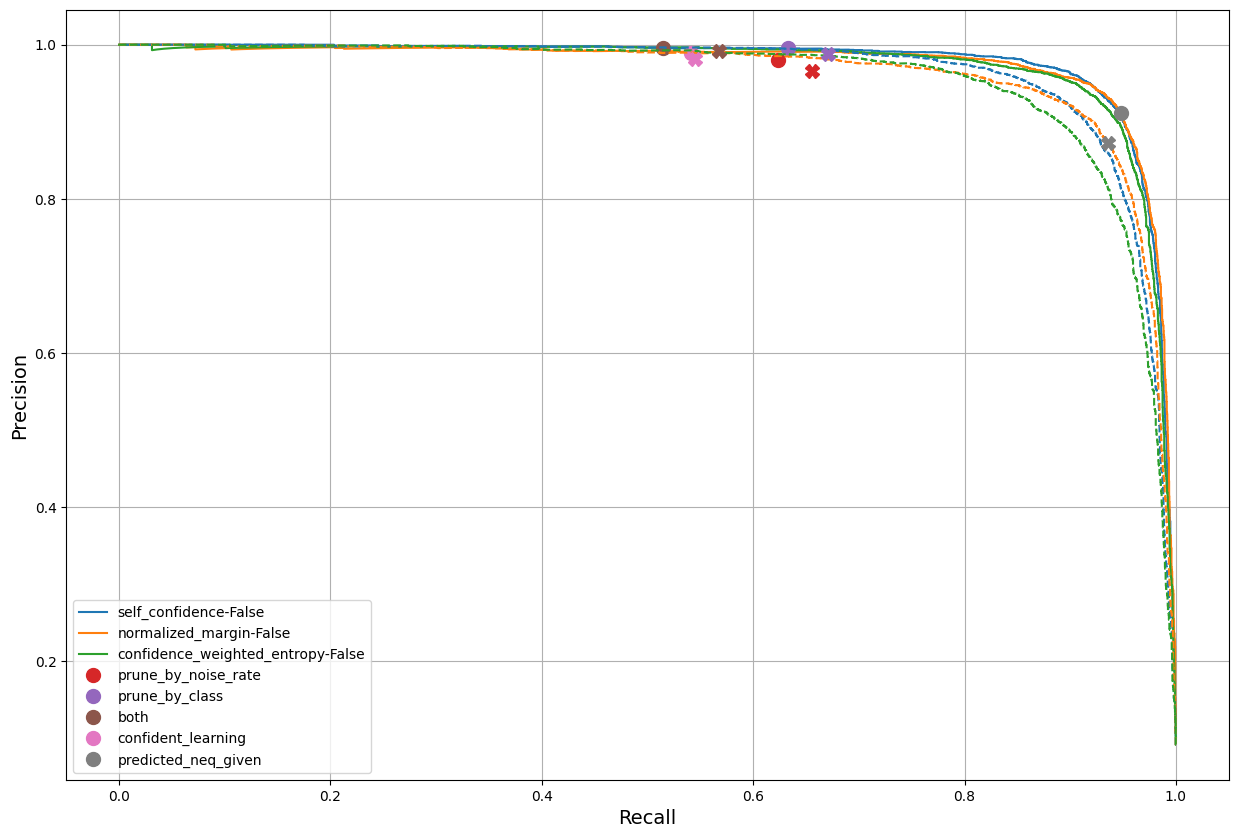

In [246]:
plot_swin_curves('cifar-10n-aggregate')

## Generating DF filter-by S2 table plots

In [50]:
models = ["swin_base_patch4_window7_224"]
datasets = ['roman-numeral', 'food-101n', 'cifar-10n-worst', 'cifar-10n-aggregate', 'cifar-10']

dfs = []
df = pd.DataFrame(experiments)

for model in models:
    for dataset in datasets:
        results = df.loc[df['model']==model].loc[df['dataset']==dataset].iloc[0]

        labels = results["labels"]
        pred_probs = results["pred_probs"]
        label_errors_target = results["label_errors_mask"]
        
        df_filter_by_xval = get_df_filter_by(labels, pred_probs, label_errors_target)
        df_filter_by_xval['model'] = model
        df_filter_by_xval['dataset'] = dataset
        
        results = df.loc[df['model']==model].loc[df['dataset']==dataset].iloc[1]

        labels = results["labels"]
        pred_probs = results["pred_probs"]
        label_errors_target = results["label_errors_mask"]
        
        df_filter_by = get_df_filter_by(labels, pred_probs, label_errors_target)
        
        delta_precision = np.round(df_filter_by["precision"].to_numpy() - df_filter_by_xval["precision"].to_numpy(),4)
        delta_recall = np.round(df_filter_by["recall"].to_numpy() - df_filter_by_xval["recall"].to_numpy(),4)
        delta_accuracy = np.round(df_filter_by["accuracy"].to_numpy() - df_filter_by_xval["accuracy"].to_numpy(),4)
        datasets = df_filter_by_xval['dataset'].tolist()
        filter_by = df_filter_by['filter_by'].tolist()
        
        df_filter = pd.DataFrame(zip(datasets,filter_by,delta_precision,delta_recall,delta_accuracy), columns=['dataset','filter_by','Δprecision', 'Δrecall', 'Δaccuracy'])
        dfs.append(df_filter)
        
dfs_filter_by = pd.concat(dfs)

In [51]:
dfs_filter_by

,dataset,filter_by,Δprecision,Δrecall,Δaccuracy
0,roman-numeral,prune_by_noise_rate,-0.3631,-0.1936,0.0002
1,roman-numeral,prune_by_class,-0.5530,-0.2742,-0.0210
2,roman-numeral,both,-0.3988,-0.1075,-0.0041
3,roman-numeral,confident_learning,-0.3007,-0.1102,0.0030
4,roman-numeral,predicted_neq_given,-0.3410,-0.5700,-0.0221
0,food-101n,prune_by_noise_rate,-0.0347,0.0219,-0.0074
1,food-101n,prune_by_class,-0.0383,0.0433,-0.0015
2,food-101n,both,-0.0309,0.0261,-0.0003
3,food-101n,confident_learning,-0.0353,0.0123,-0.0055
4,food-101n,predicted_neq_given,-0.0404,0.0213,-0.0215


## Method vs Metric scatterplots 
xval and nonxval between all models/datasets

In [52]:
import seaborn as sns

def scatterplot(evaluations, method, metric='auroc', hue='dataset'):
    plt.figure(figsize=(8,8))
    df = pd.DataFrame(evaluations)
    xval = df.loc[df['method']==method].loc[df['type_train']=='-xval'][metric].tolist()
    noxval = df.loc[df['method']==method].loc[df['type_train']==''][metric].tolist()
    hue_vals = df.loc[df['method']==method].loc[df['type_train']==''][hue].tolist()
    df = pd.DataFrame(zip(xval, noxval, hue_vals), columns=['xval','noxval',hue])
    
    plt.axline((0.5,0.5), slope=1)
    sns.scatterplot(x="xval", y="noxval", data=df, hue=hue)
    
    plt.title(f'{metric}-{method}')
    plt.savefig(f'./figs/scatter-{metric}-{method}-{len(df)}.png', dpi=300)
    plt.show()

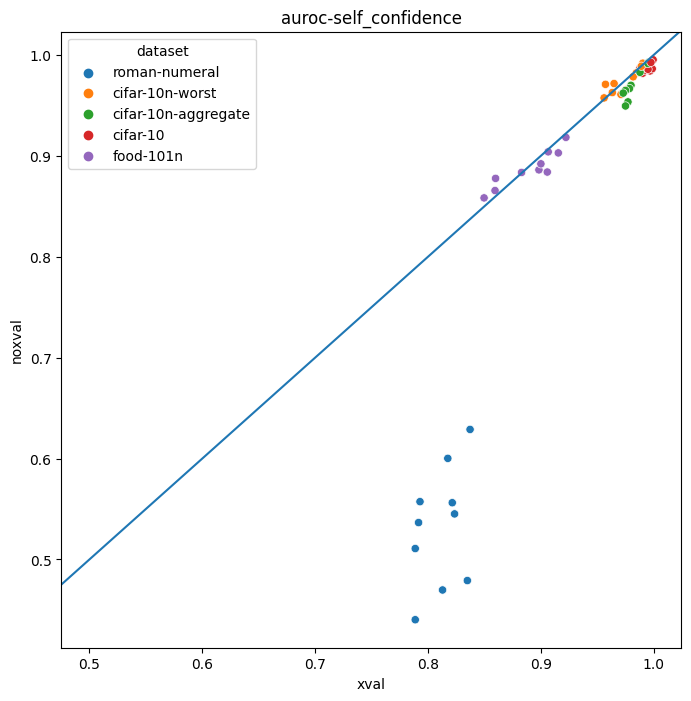

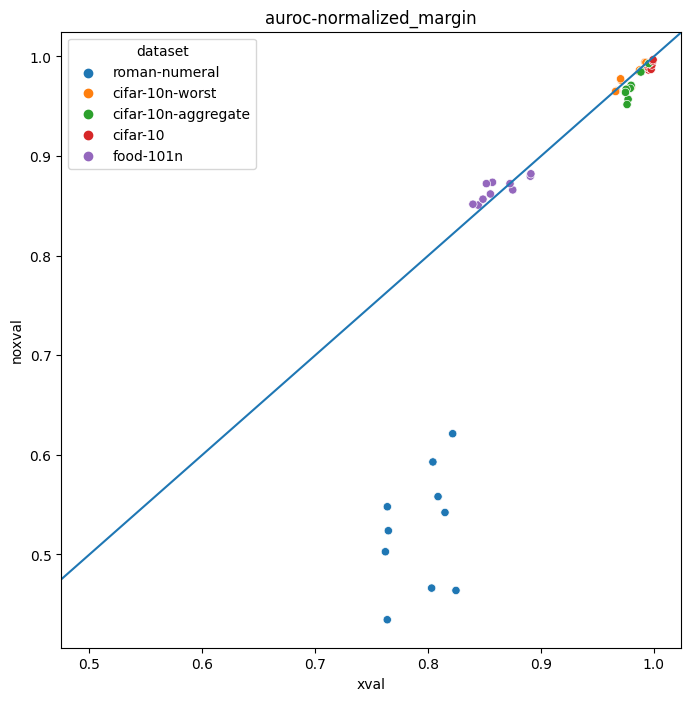

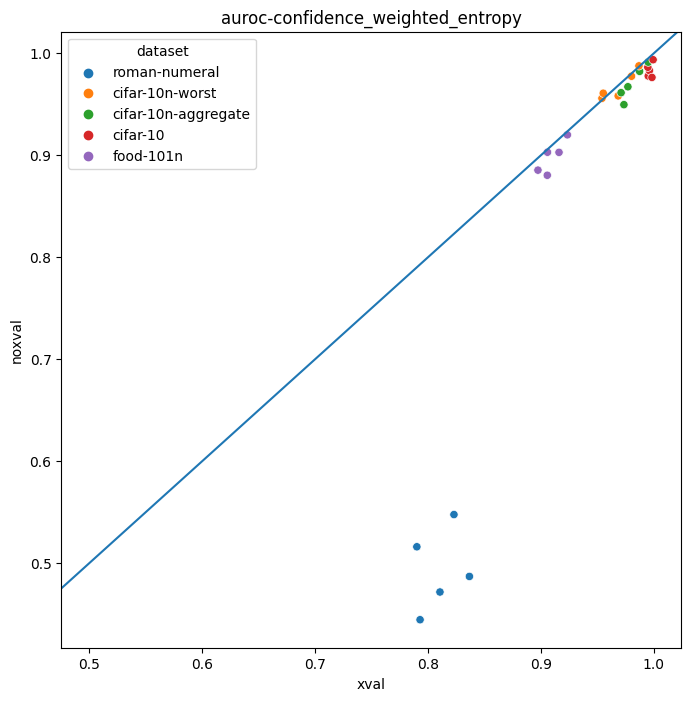

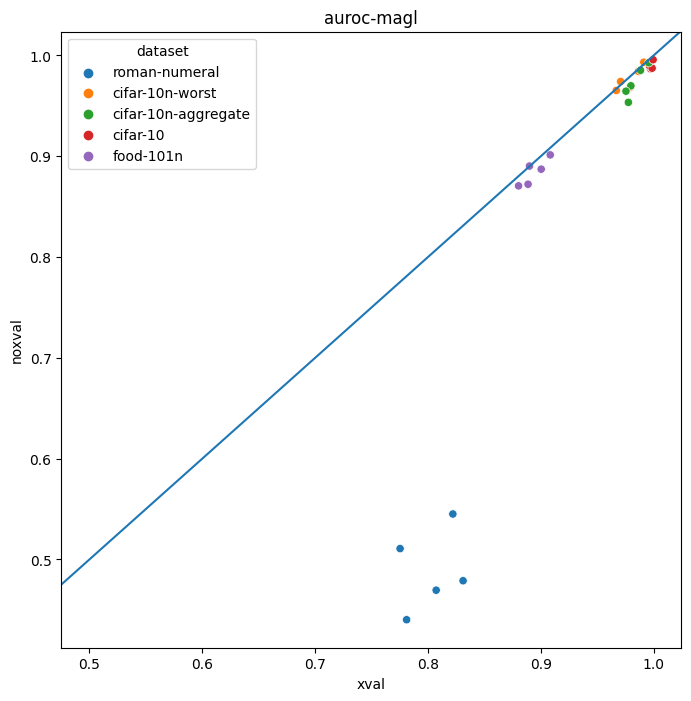

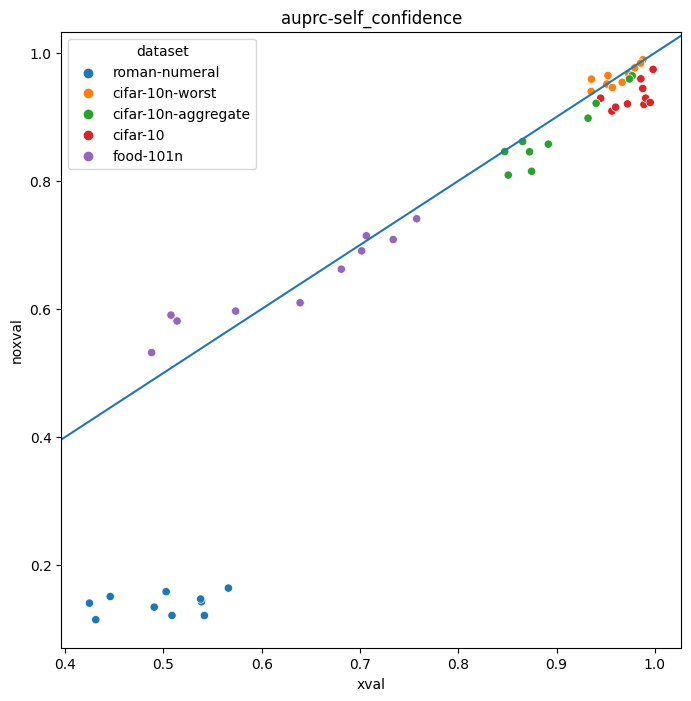

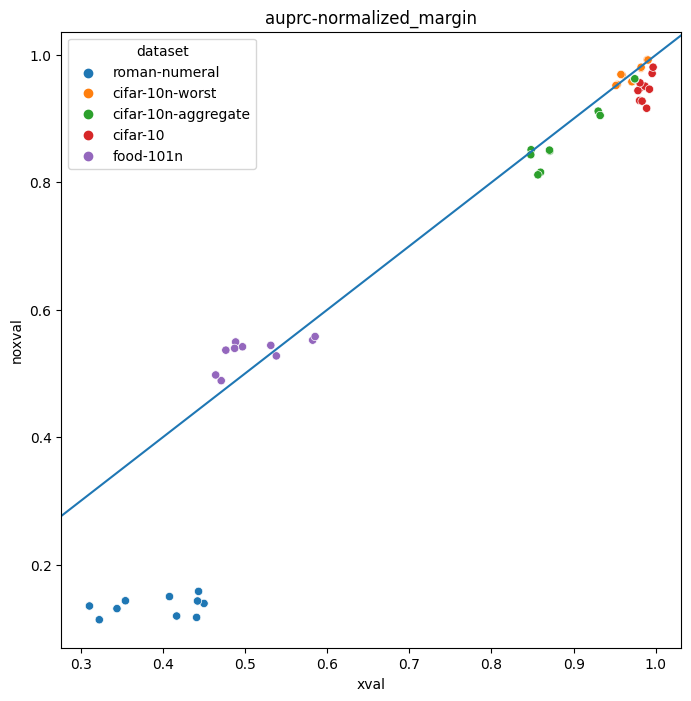

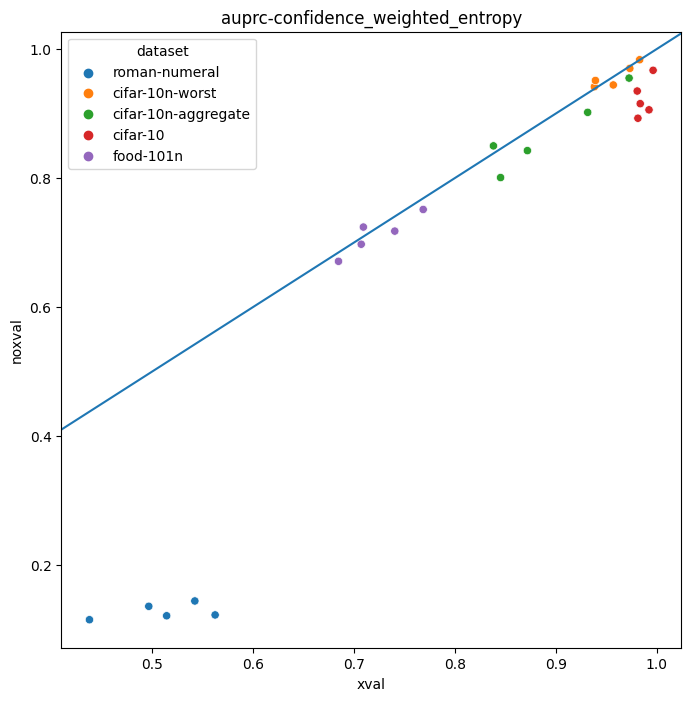

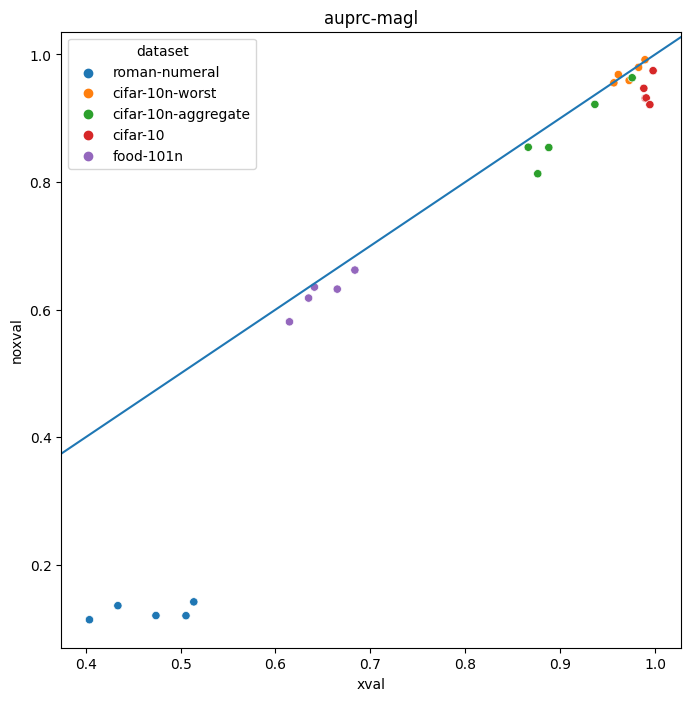

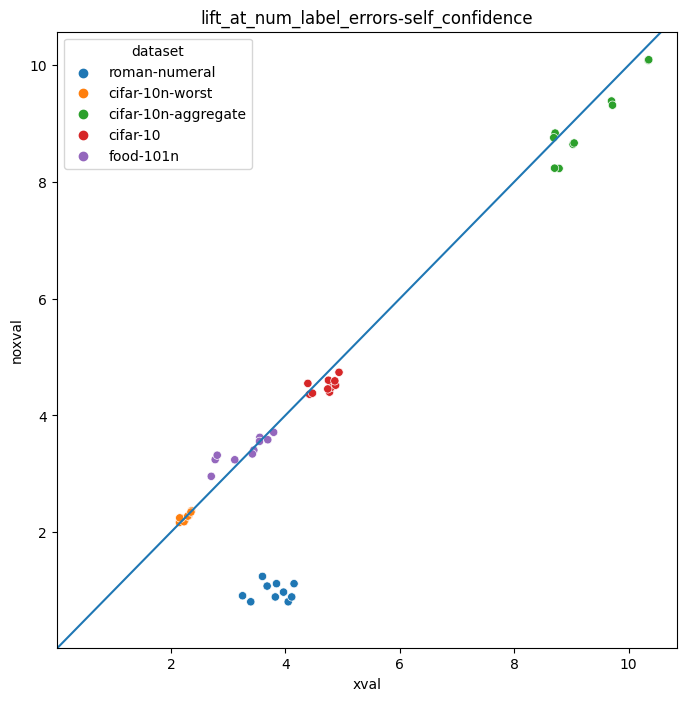

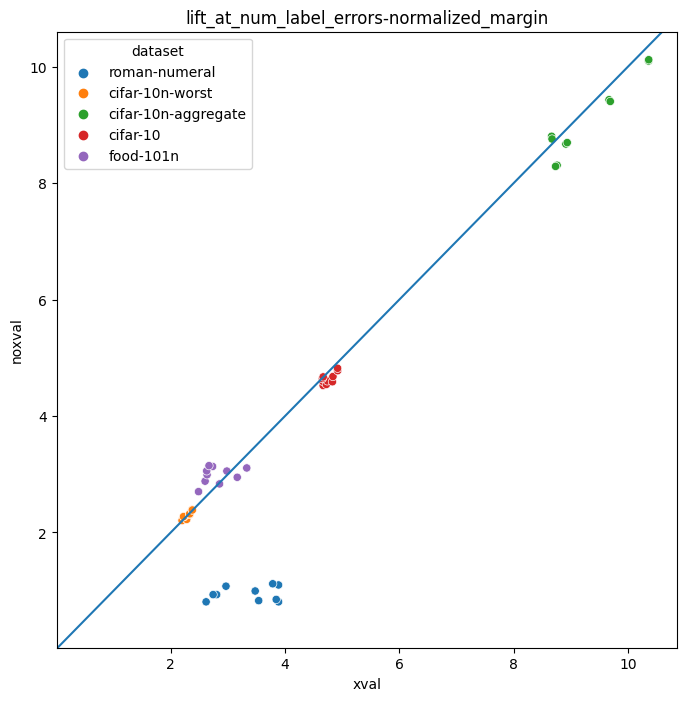

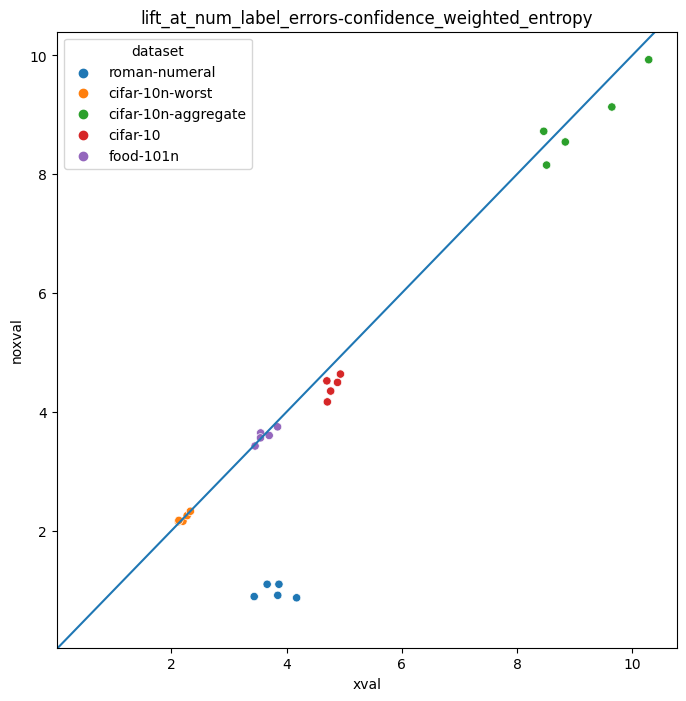

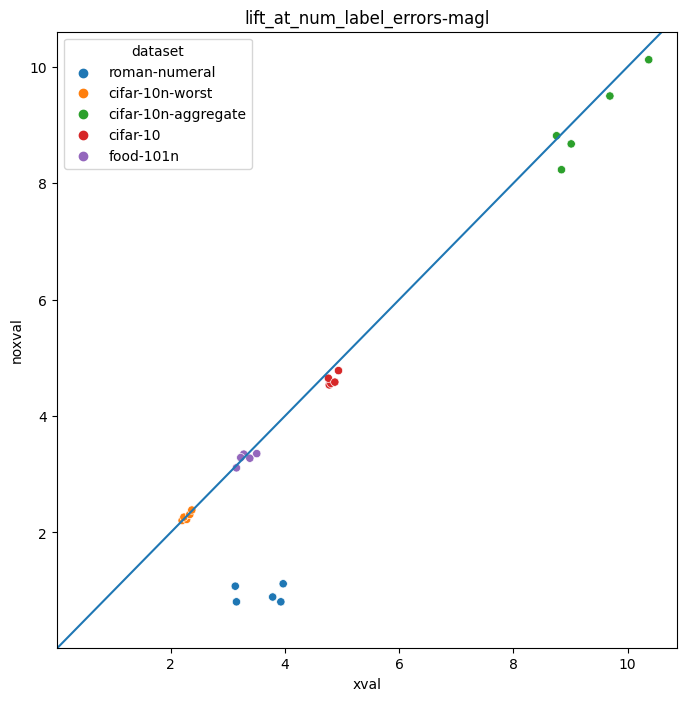

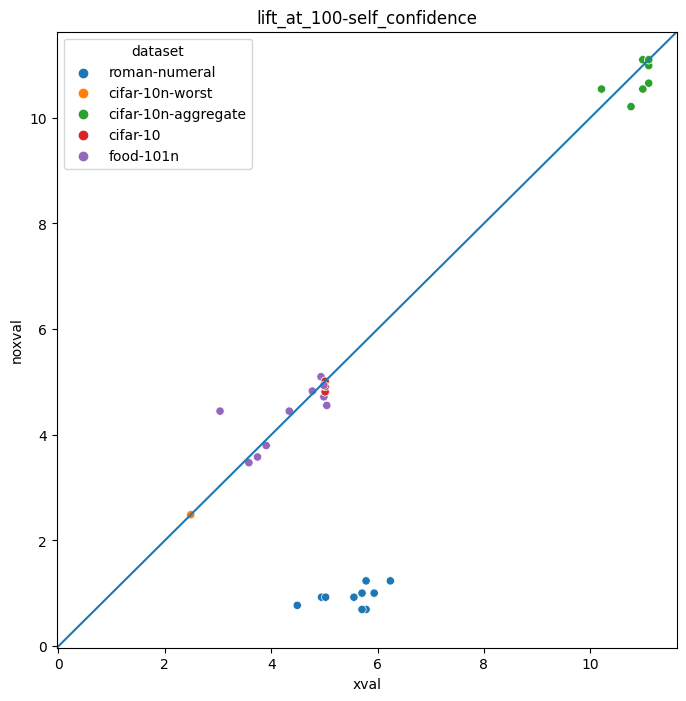

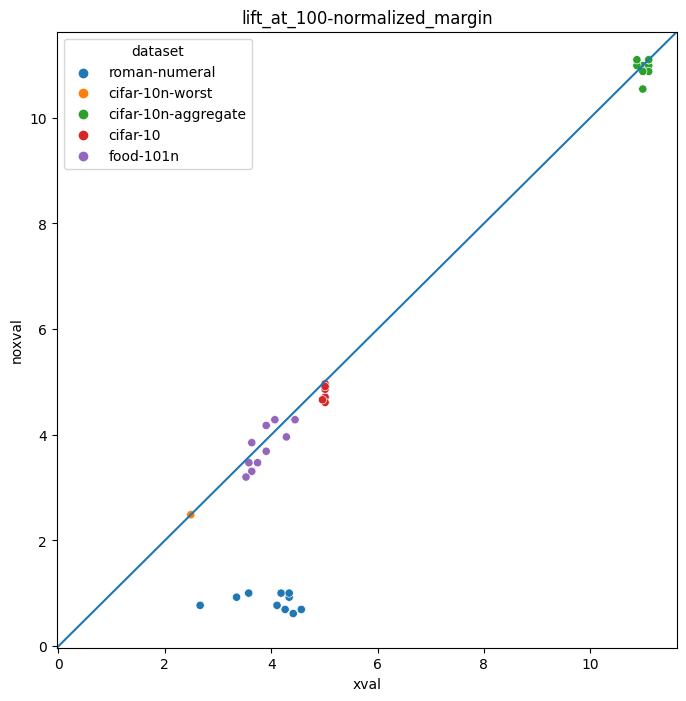

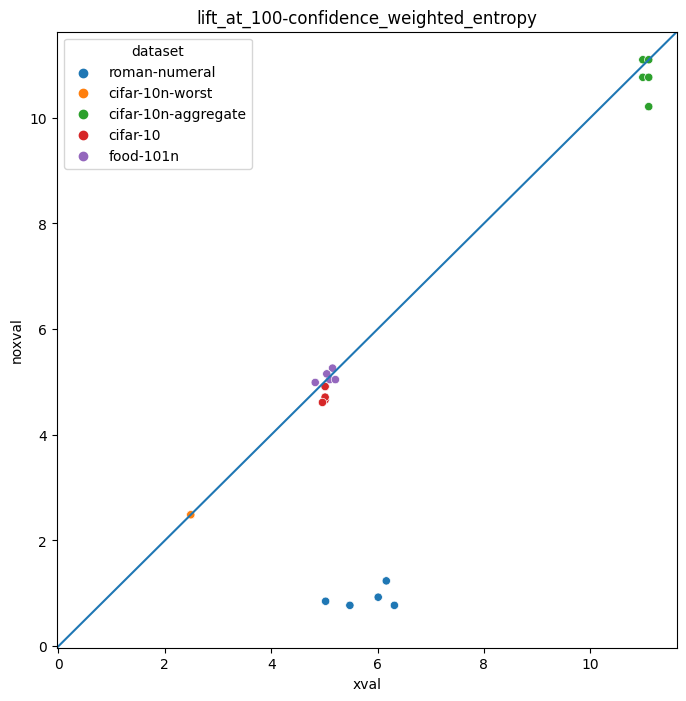

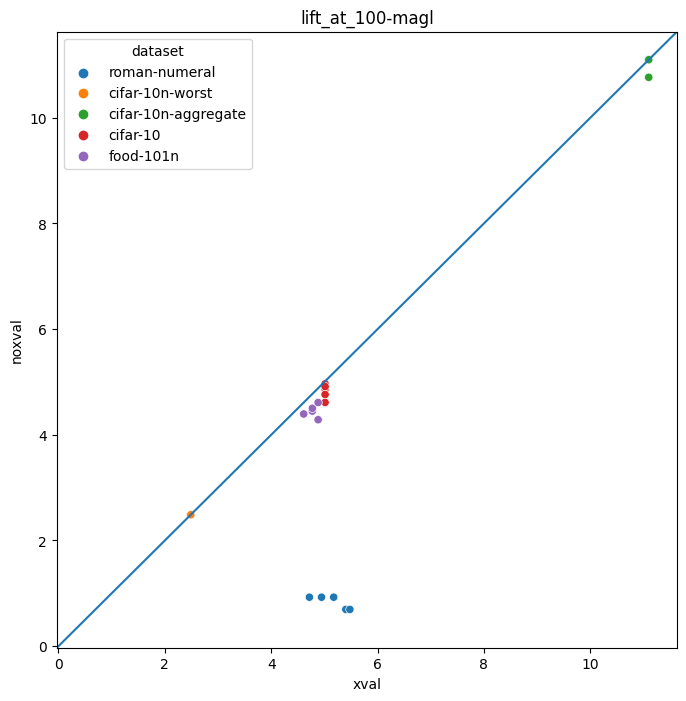

In [383]:
metrics = ['auroc','auprc','lift_at_num_label_errors','lift_at_100']
methods = ['self_confidence','normalized_margin','confidence_weighted_entropy','magl']
for metric in metrics:
    for method in methods:
        scatterplot(evaluations, method=method, metric=metric, hue='dataset')

# MAE for # of issues
(xvalidation will probably help)

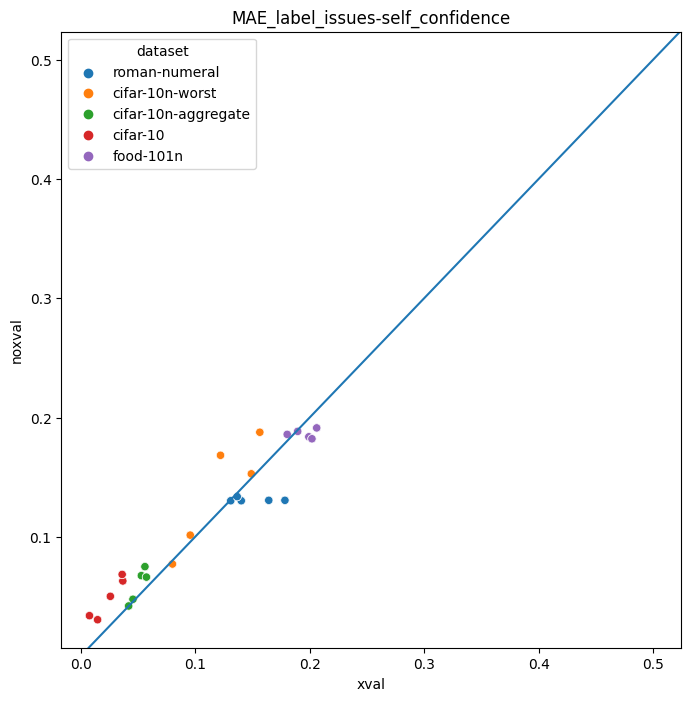

In [53]:
scatterplot(evaluations, method="self_confidence", metric="MAE_label_issues", hue='dataset')

In [99]:
xval_evaluations = evaluations[:len(evaluations)//2].copy()
noxval_evaluations = evaluations[len(evaluations)//2:].copy()

mae_results = []
seen_mae = set()

for xval,noxval in zip(xval_evaluations, noxval_evaluations):
    xval_MAE = np.round(xval["MAE_label_issues"],4)
    noxval_MAE = np.round(noxval["MAE_label_issues"],4)
    delta_MAE = np.round(xval["MAE_label_issues"] - noxval["MAE_label_issues"],4)
    
    evaluation_results = {
        "method": noxval["method"],
        "adjust_pred_probs": noxval["adjust_pred_probs"],
        "dataset": noxval["dataset"],
        "model": noxval["model"],
        "dataset_num_samples": noxval["dataset_num_samples"],
        "dataset_num_label_errors": noxval["dataset_num_label_errors"],
        "xval_MAE_label_issues": xval_MAE,
        "noxval_MAE_label_issues": noxval_MAE,
        "ΔMAE_label_issues": delta_MAE
    }
    
    seen = tuple((evaluation_results["dataset"], evaluation_results["model"]))
    if seen not in seen_mae:
        seen_mae.add(seen)
        mae_results.append(evaluation_results)

In [100]:
df = pd.DataFrame(mae_results)
df = df.sort_values(by=['dataset','model'], ascending=False)

In [101]:
df

,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,xval_MAE_label_issues,noxval_MAE_label_issues,ΔMAE_label_issues
15,self_confidence,False,roman-numeral,twins_pcpvt_base,2880,373,0.1310,0.1302,0.0008
20,self_confidence,False,roman-numeral,swin_base_patch4_window7_224,2880,373,0.1367,0.1337,0.0030
5,self_confidence,False,roman-numeral,resnet50d,2880,373,0.1643,0.1306,0.0337
0,self_confidence,False,roman-numeral,resnet18,2880,373,0.1402,0.1302,0.0100
10,self_confidence,False,roman-numeral,efficientnet_b1,2880,373,0.1784,0.1306,0.0478
19,self_confidence,False,food-101n,twins_pcpvt_base,52867,9746,0.1895,0.1884,0.0012
24,self_confidence,False,food-101n,swin_base_patch4_window7_224,52867,9746,0.1804,0.1859,-0.0055
9,self_confidence,False,food-101n,resnet50d,52867,9746,0.1993,0.1838,0.0154
4,self_confidence,False,food-101n,resnet18,52867,9746,0.2061,0.1913,0.0148
14,self_confidence,False,food-101n,efficientnet_b1,52867,9746,0.2020,0.1822,0.0198


In [ ]:
for x,y,z in zip(df['xval_MAE_label_issues'].to_list(),df['noxval_MAE_label_issues'].to_list(),df['noxval_MAE_label_issues'].to_list()):
    print(f'& {x} & {y} ')           

## Evaluate results from ensemble models
### Prepare data

In [178]:
%%time

dataset_model_output = {}

for i, experiment in enumerate(experiments):

    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    images = experiment["images"]
    label_errors_target = experiment["label_errors_mask"]

    # check
    if dataset not in dataset_model_output.keys():

        # init list of pred_probs and labels
        dataset_model_output[dataset] = {}
        dataset_model_output[dataset]["pred_probs_list"] = []
        dataset_model_output[dataset]["labels_list"] = []
        dataset_model_output[dataset]["images_list"] = []
        dataset_model_output[dataset]["label_errors_target_list"] = []

    # store model output on dataset as key
    dataset_model_output[dataset]["pred_probs_list"].append(pred_probs)
    dataset_model_output[dataset]["labels_list"].append(labels)
    dataset_model_output[dataset]["images_list"].append(images)
    dataset_model_output[dataset]["label_errors_target_list"].append(
        label_errors_target
    )

CPU times: user 84 µs, sys: 7 µs, total: 91 µs
Wall time: 94.7 µs


### Evaluate ensemble models

In [181]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]


ensemble_evaluations = []

dataset_best_weights = []

for dataset_key in dataset_model_output.keys():

    # get list of pred_probs, labels for dataset
    pred_probs_list = dataset_model_output[dataset_key]["pred_probs_list"]
    labels_list = dataset_model_output[dataset_key]["labels_list"]
    images_list = dataset_model_output[dataset_key]["images_list"]
    label_errors_target_list = dataset_model_output[dataset_key]["label_errors_target_list"]
    
    # use for sanity check (noisy labels and images from each model should be the same because they were generated from the same cross-val procedure
    for i, (labels_temp, images_temp) in enumerate(zip(labels_list, images_list)):

        if i == 0:
            labels_temp_previous = copy.deepcopy(labels_temp)
            images_temp_previous = copy.deepcopy(images_temp)       
        else:
#             assert np.sum(labels_temp_previous == labels_temp) == len(labels_temp_previous)
#             assert np.sum(images_temp_previous == images_temp) == len(images_temp_previous)
            pass
    
    # take the first (the others are the same)
    labels = labels_list[0]
    label_errors_target = label_errors_target_list[0]
    
    # compute accuracy
    accuracy_list = []
    for pred_probs in pred_probs_list:
        
        # accuracy of single model
        accuracy = (pred_probs.argmax(axis=1) == labels).mean()
        accuracy_list.append(accuracy)
        
    # accuracy weights
    acc_weights = np.array(accuracy_list) / sum(accuracy_list)    
    
    # average predictions
    pred_probs_avg = sum(pred_probs_list) / len(pred_probs_list)
    
    #### can refactor below to a function that accepts weights and pred_probs_list
    
    # accuracy-weighted predictions
    pred_probs_avg_acc_weighted = sum([acc_weights[i] * p for i, p in enumerate(pred_probs_list)])
    

    #### find best t in T for exp-log-loss weighting
    T = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 2e2]

    pred_probs_avg_log_loss_weighted = None
    inv_log_loss_weights = None
    best_eval_log_loss = float("inf")
    best_t = None

    for t in T:

        log_loss_list = []

        # pred_probs for each model
        for pred_probs in pred_probs_list:
            log_loss_ = np.exp(t * (-log_loss(labels, pred_probs)))
            log_loss_list.append(log_loss_)

        # weights using log loss
        inv_log_loss_weights_temp = np.array(log_loss_list) / sum(log_loss_list)

        # weighted average
        pred_probs_avg_log_loss_weighted_temp = sum([inv_log_loss_weights_temp[i] * p for i, p in enumerate(pred_probs_list)])

        # evaluate log_loss with this weighted average
        eval_log_loss = log_loss(labels, pred_probs_avg_log_loss_weighted_temp)

        # check if this is the best eval_log_loss so far
        if best_eval_log_loss > eval_log_loss:
            best_eval_log_loss = eval_log_loss
            best_t = t
            pred_probs_avg_log_loss_weighted = pred_probs_avg_log_loss_weighted_temp.copy()
            inv_log_loss_weights = inv_log_loss_weights_temp.copy()    

    df_temp = pd.DataFrame({
        "dataset": dataset_key,
        "models": models,
        "best_t": best_t,
        "best_eval_log_loss": best_eval_log_loss,
        "inv_log_loss_weights": inv_log_loss_weights,
    })
    
    # save the weights for analysis later
    dataset_best_weights.append(df_temp)
            
    print()
    print(dataset_key)
    print(best_eval_log_loss)
    print(inv_log_loss_weights)
    print(pred_probs_avg_log_loss_weighted)
    
    
    #### label quality scoring
    
    for score_param in score_params:
        
        # label quality scoring method
        method, adjust_pred_probs = score_param
    
        # compute scores
        
        # use average pred_probs
        label_quality_scores_avg = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by accuracy
        label_quality_scores_avg_acc_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_acc_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by log loss
        label_quality_scores_avg_log_loss_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_log_loss_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use pred_probs_list (weighted by accuracy)
        label_quality_scores_agg_acc = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs, 
            verbose=0,
            weight_ensemble_members_by="accuracy"
        )

        # use pred_probs_list (uniform_weights)
        label_quality_scores_agg_uni = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0,
            weight_ensemble_members_by="uniform"
        )
        
        # use pred_probs_list (weight by inverse log loss)
        label_quality_scores_agg_log_loss = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0, 
            weight_ensemble_members_by="custom",
            custom_weights=inv_log_loss_weights # custom weights!
        )        
        
        # compute accuracy of detecting label errors
        auroc_avg = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg)
        auroc_avg_acc_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_acc_weighted)
        auroc_avg_log_loss_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted)        
        
        auroc_agg_acc = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_acc)
        auroc_agg_uni = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_uni)
        auroc_agg_log_loss = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_log_loss)        
        
        # lift at K where K = number of label errors
        lift_at_num_label_errors_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=label_errors_target.sum())
        
        lift_at_num_label_errors_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=label_errors_target.sum())        
        
        # lift at k=100
        lift_at_100_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=100)
        lift_at_100_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=100)
        lift_at_100_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=100)
        
        lift_at_100_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=100)
        lift_at_100_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=100)
        lift_at_100_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=100)

        ensemble_evaluation_results_avg = {
            "ensemble_method": "avg_pred_probs",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg,
            "lift_at_100": lift_at_100_avg
        }
        
        ensemble_evaluation_results_avg_acc_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_acc_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_acc_weighted,
            "lift_at_100": lift_at_100_avg_acc_weighted
        }        
        
        ensemble_evaluation_results_avg_log_loss_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_log_loss_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_log_loss_weighted,
            "lift_at_100": lift_at_100_avg_log_loss_weighted
        }                
        
        ensemble_evaluation_results_agg_acc = {
            "ensemble_method": "avg_scores_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_acc,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_acc,
            "lift_at_100": lift_at_100_agg_acc
        }
        
        ensemble_evaluation_results_agg_uni = {
            "ensemble_method": "avg_scores",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_uni,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_uni,
            "lift_at_100": lift_at_100_agg_uni
        }
        
        ensemble_evaluation_results_agg_log_loss = {
            "ensemble_method": "avg_scores_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_log_loss,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_log_loss,
            "lift_at_100": lift_at_100_agg_log_loss
        }
        
        # store evaluation results
        ensemble_evaluations.append(ensemble_evaluation_results_avg)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_acc_weighted)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_log_loss_weighted)
        
        ensemble_evaluations.append(ensemble_evaluation_results_agg_acc)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_uni)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_log_loss)

<timed exec>:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


AttributeError: 'bool' object has no attribute 'mean'

In [ ]:
df_evaluations_ensemble = pd.DataFrame(ensemble_evaluations)

df_evaluations_ensemble["method_adjust_pred_probs"] = (
    df_evaluations_ensemble.method
    + "-"
    + df_evaluations_ensemble.adjust_pred_probs.astype(str)
)
df_evaluations_ensemble["dataset_model"] = (
    df_evaluations_ensemble.dataset + " | " + df_evaluations_ensemble.model
)

df_evaluations_ensemble[
    "scoring_method"
] = df_evaluations_ensemble.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)

In [ ]:
df_evaluations_ensemble.head(3)

In [ ]:
df_evaluations_ensemble.groupby("ensemble_method")["ensemble_method"].count()

In [ ]:
df_evaluations_ensemble_pivot = pd.pivot_table(
    df_evaluations_ensemble,
    values="auroc",
    index=["scoring_method", "ensemble_method"],
    columns=["dataset"],
).reset_index()

In [ ]:
df_evaluations_ensemble_pivot.head(2)

In [ ]:
df_evaluations_ensemble_auroc = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="auroc",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_num_errors = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_num_label_errors",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_100 = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_100",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_auroc["dataset_scoring_method"] = \
    df_evaluations_ensemble_auroc.dataset + " | " + df_evaluations_ensemble_auroc.scoring_method

df_evaluations_ensemble_lift_at_num_errors["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_num_errors.dataset + " | " + df_evaluations_ensemble_lift_at_num_errors.scoring_method

df_evaluations_ensemble_lift_at_100["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_100.dataset + " | " + df_evaluations_ensemble_lift_at_100.scoring_method

df_evaluations_ensemble_lift_at_100.head()

In [ ]:
df_evaluations_ensemble_auroc.head(3)